<a href="https://colab.research.google.com/github/Ryukijano/PyTorch-Differentiable-Stochastic-Differential-Equations/blob/main/pytorch_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PIP Implementation of Differentiable SDE Solvers | GAN implementation using SDE

In [ ]:
!pip install torchsde


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 11.8 MB/s eta 0:00:00


![Alt Text](https://raw.githubusercontent.com/google-research/torchsde/master/assets/latent_sde.gif)

In [ ]:
import torch
import torchsde

batch_size, state_size, brownian_size = 32, 3, 2
t_size = 20

class SDE(torch.nn.Module):
    noise_type = 'general'
    sde_type = 'ito'

    def __init__(self):
        super().__init__()
        self.mu = torch.nn.Linear(state_size, 
                                  state_size)
        self.sigma = torch.nn.Linear(state_size, 
                                     state_size * brownian_size)

    # Drift
    def f(self, t, y):
        return self.mu(y)  # shape (batch_size, state_size)

    # Diffusion
    def g(self, t, y):
        return self.sigma(y).view(batch_size, 
                                  state_size, 
                                  brownian_size)

sde = SDE()
y0 = torch.full((batch_size, state_size), 0.1)
ts = torch.linspace(0, 1, t_size)
# Initial state y0, the SDE is solved over the interval [ts[0], ts[-1]].
# ys will have shape (t_size, batch_size, state_size)
ys = torchsde.sdeint(sde, y0, ts)

In [ ]:
print(ys)

tensor([[[ 0.1000,  0.1000,  0.1000],
         [ 0.1000,  0.1000,  0.1000],
         [ 0.1000,  0.1000,  0.1000],
         ...,
         [ 0.1000,  0.1000,  0.1000],
         [ 0.1000,  0.1000,  0.1000],
         [ 0.1000,  0.1000,  0.1000]],

        [[-0.1443,  0.1924, -0.1114],
         [-0.2441,  0.1404,  0.0384],
         [ 0.1805,  0.1814, -0.1288],
         ...,
         [ 0.0828,  0.0917,  0.0261],
         [ 0.1004,  0.0957,  0.0209],
         [-0.1686,  0.1380,  0.0123]],

        [[ 0.0389,  0.1175, -0.0434],
         [-0.0924,  0.0076,  0.3027],
         [ 0.2038,  0.0988,  0.0042],
         ...,
         [ 0.3622, -0.0197,  0.1656],
         [-0.0052,  0.0804,  0.0141],
         [-0.3504,  0.1641, -0.0559]],

        ...,

        [[-0.1636, -0.5144,  0.3909],
         [-0.1849, -0.5386,  0.4456],
         [ 0.1194, -0.3123, -0.4978],
         ...,
         [ 0.0090, -0.4242,  0.1374],
         [ 0.0446,  0.0332, -0.4238],
         [-0.1282, -0.5379,  0.5305]],

        [[

In [ ]:
!pip install fire
!pip install torchcde
!pip install torchsde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116952 sha256=8f7060d6c289786cfaa623c532338bbf00d71095c55f3554ed2db5dec2da4c2e
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fire
import matplotlib.pyplot as plt
import torch 
import torch.optim.swa_utils as swa_utils 
import torchcde
import torchsde
import tqdm

In [ ]:
###################
# First some standard helper objects.
###################

class LipSwish(torch.nn.Module):
  def forward(self, x):
    return 0.99 * torch.nn.functional.silu(x)

class MLP(torch.nn.Module):
  def __init__(self, in_size, out_size, mlp_size, num_layers, tanh):
    super().__init__()

    model = [torch.nn.Linear(in_size, mlp_size),
             LipSwish()]

    for _ in range(num_layers -1):
      model.append(torch.nn.Linear(in_size, mlp_size))
            ###################
            # LipSwish activations are useful to constrain the Lipschitz constant of the discriminator.
            # (For simplicity we additionally use them in the generator, but that's less important.)
            ###################
      model.append(LipSwish())
    model.append(torch.nn.Linear(mlp_size, out_size))
    if tanh:
      model.append(torch.nn.Tanh())
    self._model = torch.nn.Sequential(*model)

  def forward(self, x):
    return self._model(x)

###################
# Now we define the SDEs.
#
# We begin by defining the generator SDE.
################### 
class GeneratorFunc(torch.nn.Module):
  sde_type = 'stratonovich'
  noise_type = 'general'

  def __init__(self, noise_size, hidden_size, mlp_size, num_layers):
    super().__init__()
    self._noise_size = noise_size
    self._hidden_size = hidden_size

        ###################
        # Drift and diffusion are MLPs. They happen to be the same size.
        # Note the final tanh nonlinearity: this is typically important for good performance, to constrain the rate of
        # change of the hidden state.
        # If you have problems with very high drift/diffusions then consider scaling these so that they squash to e.g.
        # [-3, 3] rather than [-1, 1].
        ###################
    self._drift = MLP(1 + hidden_size, hidden_size, mlp_size, num_layers, tanh=True)
    self._diffusion = MLP(1 + hidden_size, hidden_size * noise_size, mlp_size, num_layers, tanh=True)
    
  def f_and_g(self, t, x):
    # t has shape ()
    # x has shape (batch_size, hidden_size)
    t = t.expand(x.size(0), 1)
    tx = torch.cat([t, x], dim=1)
    return self._drift(tx), self._diffusion(tx).view(x.size(0), self._hidden_size, self._noise_size)

###################
# Now we wrap it up into something that computes the SDE.
###################
class Generator(torch.nn.Module):
    def __init__(self, data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._initial_noise_size = initial_noise_size
        self._hidden_size = hidden_size

        self._initial = MLP(initial_noise_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = GeneratorFunc(noise_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, data_size)

    def forward(self, ts, batch_size):
        # ts has shape (t_size,) and corresponds to the points we want to evaluate the SDE at.

        ###################
        # Actually solve the SDE.
        ###################
        init_noise = torch.randn(batch_size, self._initial_noise_size, device=ts.device)
        x0 = self._initial(init_noise)

        ###################
        # We use the reversible Heun method to get accurate gradients whilst using the adjoint method.
        ###################
        xs = torchsde.sdeint_adjoint(self._func, x0, ts, method='reversible_heun', dt=1.0,
                                     adjoint_method='adjoint_reversible_heun',)
        xs = xs.transpose(0, 1)
        ys = self._readout(xs)

        ###################
        # Normalise the data to the form that the discriminator expects, in particular including time as a channel.
        ###################
        ts = ts.unsqueeze(0).unsqueeze(-1).expand(batch_size, ts.size(0), 1)
        return torchcde.linear_interpolation_coeffs(torch.cat([ts, ys], dim=2))

  


In [ ]:
###################
# Next the discriminator. Here, we're going to use a neural controlled differential equation (neural CDE) as the
# discriminator, just as in the "Neural SDEs as Infinite-Dimensional GANs" paper. (You could use other things as well,
# but this is a natural choice.)
#
# There's actually a few different (roughly equivalent) ways of making the discriminator work. The curious reader is
# encouraged to have a read of the comment at the bottom of this file for an in-depth explanation.
###################
class DiscriminatorFunc(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()
        self._data_size = data_size
        self._hidden_size = hidden_size

        # tanh is important for model performance
        self._module = MLP(1 + hidden_size, hidden_size * (1 + data_size), mlp_size, num_layers, tanh=True)

    def forward(self, t, h):
        # t has shape ()
        # h has shape (batch_size, hidden_size)
        t = t.expand(h.size(0), 1)
        th = torch.cat([t, h], dim=1)
        return self._module(th).view(h.size(0), self._hidden_size, 1 + self._data_size)

class Discriminator(torch.nn.Module):
    def __init__(self, data_size, hidden_size, mlp_size, num_layers):
        super().__init__()

        self._initial = MLP(1 + data_size, hidden_size, mlp_size, num_layers, tanh=False)
        self._func = DiscriminatorFunc(data_size, hidden_size, mlp_size, num_layers)
        self._readout = torch.nn.Linear(hidden_size, 1)

    def forward(self, ys_coeffs):
        # ys_coeffs has shape (batch_size, t_size, 1 + data_size)
        # The +1 corresponds to time. When solving CDEs, It turns out to be most natural to treat time as just another
        # channel: in particular this makes handling irregular data quite easy, when the times may be different between
        # different samples in the batch.

        Y = torchcde.LinearInterpolation(ys_coeffs)
        Y0 = Y.evaluate(Y.interval[0])
        h0 = self._initial(Y0)
        hs = torchcde.cdeint(Y, self._func, h0, Y.interval, method='reversible_heun', backend='torchsde', dt=1.0,
                             adjoint_method='adjoint_reversible_heun',
                             adjoint_params=(ys_coeffs,) + tuple(self._func.parameters()))
        score = self._readout(hs[:, -1])
        return score.mean()

In [ ]:
###################
# Generate some data. For this example we generate some synthetic data from a time-dependent Ornstein-Uhlenbeck SDE.
###################
def get_data(batch_size, device):
    dataset_size = 8192
    t_size = 64

    class OrnsteinUhlenbeckSDE(torch.nn.Module):
        sde_type = 'ito'
        noise_type = 'scalar'

        def __init__(self, mu, theta, sigma):
            super().__init__()
            self.register_buffer('mu', torch.as_tensor(mu))
            self.register_buffer('theta', torch.as_tensor(theta))
            self.register_buffer('sigma', torch.as_tensor(sigma))

        def f(self, t, y):
            return self.mu * t - self.theta * y

        def g(self, t, y):
            return self.sigma.expand(y.size(0), 1, 1) * (2 * t / t_size)

    ou_sde = OrnsteinUhlenbeckSDE(mu=0.02, theta=0.1, sigma=0.4).to(device)
    y0 = torch.rand(dataset_size, device=device).unsqueeze(-1) * 2 - 1
    ts = torch.linspace(0, t_size - 1, t_size, device=device)
    ys = torchsde.sdeint(ou_sde, y0, ts, dt=1e-1)

    ###################
    # To demonstrate how to handle irregular data, then here we additionally drop some of the data (by setting it to
    # NaN.)
    ###################
    ys_num = ys.numel()
    to_drop = torch.randperm(ys_num)[:int(0.3 * ys_num)]
    ys.view(-1)[to_drop] = float('nan')

    ###################
    # Typically important to normalise data. Note that the data is normalised with respect to the statistics of the
    # initial data, _not_ the whole time series. This seems to help the learning process, presumably because if the
    # initial condition is wrong then it's pretty hard to learn the rest of the SDE correctly.
    ###################
    y0_flat = ys[0].view(-1)
    y0_not_nan = y0_flat.masked_select(~torch.isnan(y0_flat))
    ys = (ys - y0_not_nan.mean()) / y0_not_nan.std()

    ###################
    # As discussed, time must be included as a channel for the discriminator.
    ###################
    ys = torch.cat([ts.unsqueeze(0).unsqueeze(-1).expand(dataset_size, t_size, 1),
                    ys.transpose(0, 1)], dim=2)
    # shape (dataset_size=1000, t_size=100, 1 + data_size=3)

    ###################
    # Package up.
    ###################
    data_size = ys.size(-1) - 1  # How many channels the data has (not including time, hence the minus one).
    ys_coeffs = torchcde.linear_interpolation_coeffs(ys)  # as per neural CDEs.
    dataset = torch.utils.data.TensorDataset(ys_coeffs)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return ts, data_size, dataloader    


In [ ]:
###################
# We'll plot some results at the end.
###################
def plot(ts, generator, dataloader, num_plot_samples, plot_locs):
    # Get samples
    real_samples, = next(iter(dataloader))
    assert num_plot_samples <= real_samples.size(0)
    real_samples = torchcde.LinearInterpolation(real_samples).evaluate(ts)
    real_samples = real_samples[..., 1]

    with torch.no_grad():
        generated_samples = generator(ts, real_samples.size(0)).cpu()
    generated_samples = torchcde.LinearInterpolation(generated_samples).evaluate(ts)
    generated_samples = generated_samples[..., 1]

    # Plot histograms
    for prop in plot_locs:
        time = int(prop * (real_samples.size(1) - 1))
        real_samples_time = real_samples[:, time]
        generated_samples_time = generated_samples[:, time]
        _, bins, _ = plt.hist(real_samples_time.cpu().numpy(), bins=32, alpha=0.7, label='Real', color='dodgerblue',
                              density=True)
        bin_width = bins[1] - bins[0]
        num_bins = int((generated_samples_time.max() - generated_samples_time.min()).item() // bin_width)
        plt.hist(generated_samples_time.cpu().numpy(), bins=num_bins, alpha=0.7, label='Generated', color='crimson',
                 density=True)
        plt.legend()
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.title(f'Marginal distribution at time {time}.')
        plt.tight_layout()
        plt.show()

    real_samples = real_samples[:num_plot_samples]
    generated_samples = generated_samples[:num_plot_samples]

    # Plot samples
    real_first = True
    generated_first = True
    for real_sample_ in real_samples:
        kwargs = {'label': 'Real'} if real_first else {}
        plt.plot(ts.cpu(), real_sample_.cpu(), color='dodgerblue', linewidth=0.5, alpha=0.7, **kwargs)
        real_first = False
    for generated_sample_ in generated_samples:
        kwargs = {'label': 'Generated'} if generated_first else {}
        plt.plot(ts.cpu(), generated_sample_.cpu(), color='crimson', linewidth=0.5, alpha=0.7, **kwargs)
        generated_first = False
    plt.legend()
    plt.title(f"{num_plot_samples} samples from both real and generated distributions.")
    plt.tight_layout()
    plt.show()


  0%|          | 1/10000 [00:02<7:37:27,  2.75s/it]

Step:   0 Loss (unaveraged): -0.0330


  0%|          | 11/10000 [00:11<3:29:26,  1.26s/it]

Step:  10 Loss (unaveraged): -0.0343


  0%|          | 21/10000 [00:21<4:04:11,  1.47s/it]

Step:  20 Loss (unaveraged): -0.0364


  0%|          | 31/10000 [00:30<3:31:31,  1.27s/it]

Step:  30 Loss (unaveraged): -0.0331


  0%|          | 41/10000 [00:40<3:47:45,  1.37s/it]

Step:  40 Loss (unaveraged): -0.0362


  1%|          | 51/10000 [00:48<3:24:44,  1.23s/it]

Step:  50 Loss (unaveraged): -0.0345


  1%|          | 61/10000 [00:57<3:23:58,  1.23s/it]

Step:  60 Loss (unaveraged): -0.0331


  1%|          | 71/10000 [01:07<3:33:37,  1.29s/it]

Step:  70 Loss (unaveraged): -0.0358


  1%|          | 81/10000 [01:16<3:52:17,  1.41s/it]

Step:  80 Loss (unaveraged): -0.0360


  1%|          | 91/10000 [01:24<3:20:53,  1.22s/it]

Step:  90 Loss (unaveraged): -0.0359


  1%|          | 101/10000 [01:34<3:23:47,  1.24s/it]

Step: 100 Loss (unaveraged): -0.0369


  1%|          | 111/10000 [01:43<3:32:31,  1.29s/it]

Step: 110 Loss (unaveraged): -0.0383


  1%|          | 121/10000 [01:52<3:47:21,  1.38s/it]

Step: 120 Loss (unaveraged): -0.0366


  1%|▏         | 131/10000 [02:01<3:19:48,  1.21s/it]

Step: 130 Loss (unaveraged): -0.0375


  1%|▏         | 141/10000 [02:10<3:23:35,  1.24s/it]

Step: 140 Loss (unaveraged): -0.0366


  2%|▏         | 151/10000 [02:19<3:36:36,  1.32s/it]

Step: 150 Loss (unaveraged): -0.0368


  2%|▏         | 161/10000 [02:29<3:47:20,  1.39s/it]

Step: 160 Loss (unaveraged): -0.0378


  2%|▏         | 171/10000 [02:37<3:18:21,  1.21s/it]

Step: 170 Loss (unaveraged): -0.0371


  2%|▏         | 181/10000 [02:46<3:27:44,  1.27s/it]

Step: 180 Loss (unaveraged): -0.0390


  2%|▏         | 191/10000 [02:56<3:30:15,  1.29s/it]

Step: 190 Loss (unaveraged): -0.0378


  2%|▏         | 201/10000 [03:05<3:45:53,  1.38s/it]

Step: 200 Loss (unaveraged): -0.0374


  2%|▏         | 211/10000 [03:13<3:17:59,  1.21s/it]

Step: 210 Loss (unaveraged): -0.0364


  2%|▏         | 221/10000 [03:23<3:22:00,  1.24s/it]

Step: 220 Loss (unaveraged): -0.0343


  2%|▏         | 231/10000 [03:32<3:30:41,  1.29s/it]

Step: 230 Loss (unaveraged): -0.0391


  2%|▏         | 241/10000 [03:42<3:50:45,  1.42s/it]

Step: 240 Loss (unaveraged): -0.0382


  3%|▎         | 251/10000 [03:51<3:26:13,  1.27s/it]

Step: 250 Loss (unaveraged): -0.0350


  3%|▎         | 261/10000 [04:00<3:23:17,  1.25s/it]

Step: 260 Loss (unaveraged): -0.0350


  3%|▎         | 271/10000 [04:09<3:22:05,  1.25s/it]

Step: 270 Loss (unaveraged): -0.0352


  3%|▎         | 281/10000 [04:19<3:45:14,  1.39s/it]

Step: 280 Loss (unaveraged): -0.0362


  3%|▎         | 291/10000 [04:27<3:18:08,  1.22s/it]

Step: 290 Loss (unaveraged): -0.0317


  3%|▎         | 301/10000 [04:37<3:17:31,  1.22s/it]

Step: 300 Loss (unaveraged): -0.0332


  3%|▎         | 311/10000 [04:46<3:23:44,  1.26s/it]

Step: 310 Loss (unaveraged): -0.0315


  3%|▎         | 321/10000 [04:55<3:47:45,  1.41s/it]

Step: 320 Loss (unaveraged): -0.0300


  3%|▎         | 331/10000 [05:04<3:17:42,  1.23s/it]

Step: 330 Loss (unaveraged): -0.0316


  3%|▎         | 341/10000 [05:13<3:16:45,  1.22s/it]

Step: 340 Loss (unaveraged): -0.0306


  4%|▎         | 351/10000 [05:22<3:21:23,  1.25s/it]

Step: 350 Loss (unaveraged): -0.0318


  4%|▎         | 361/10000 [05:32<3:42:46,  1.39s/it]

Step: 360 Loss (unaveraged): -0.0307


  4%|▎         | 371/10000 [05:40<3:14:33,  1.21s/it]

Step: 370 Loss (unaveraged): -0.0302


  4%|▍         | 381/10000 [05:49<3:16:40,  1.23s/it]

Step: 380 Loss (unaveraged): -0.0283


  4%|▍         | 391/10000 [05:59<3:26:32,  1.29s/it]

Step: 390 Loss (unaveraged): -0.0274


  4%|▍         | 401/10000 [06:08<3:39:41,  1.37s/it]

Step: 400 Loss (unaveraged): -0.0271


  4%|▍         | 411/10000 [06:16<3:14:46,  1.22s/it]

Step: 410 Loss (unaveraged): -0.0276


  4%|▍         | 421/10000 [06:26<3:16:13,  1.23s/it]

Step: 420 Loss (unaveraged): -0.0271


  4%|▍         | 431/10000 [06:35<3:22:57,  1.27s/it]

Step: 430 Loss (unaveraged): -0.0288


  4%|▍         | 441/10000 [06:44<3:40:03,  1.38s/it]

Step: 440 Loss (unaveraged): -0.0274


  5%|▍         | 451/10000 [06:53<3:14:53,  1.22s/it]

Step: 450 Loss (unaveraged): -0.0264


  5%|▍         | 461/10000 [07:02<3:20:04,  1.26s/it]

Step: 460 Loss (unaveraged): -0.0274


  5%|▍         | 471/10000 [07:11<3:18:05,  1.25s/it]

Step: 470 Loss (unaveraged): -0.0271


  5%|▍         | 481/10000 [07:20<3:40:49,  1.39s/it]

Step: 480 Loss (unaveraged): -0.0280


  5%|▍         | 491/10000 [07:29<3:13:20,  1.22s/it]

Step: 490 Loss (unaveraged): -0.0275


  5%|▌         | 501/10000 [07:38<3:11:32,  1.21s/it]

Step: 500 Loss (unaveraged): -0.0280


  5%|▌         | 511/10000 [07:48<3:20:26,  1.27s/it]

Step: 510 Loss (unaveraged): -0.0292


  5%|▌         | 521/10000 [07:57<3:36:29,  1.37s/it]

Step: 520 Loss (unaveraged): -0.0302


  5%|▌         | 531/10000 [08:05<3:14:26,  1.23s/it]

Step: 530 Loss (unaveraged): -0.0319


  5%|▌         | 541/10000 [08:15<3:12:47,  1.22s/it]

Step: 540 Loss (unaveraged): -0.0319


  6%|▌         | 551/10000 [08:24<3:21:03,  1.28s/it]

Step: 550 Loss (unaveraged): -0.0320


  6%|▌         | 561/10000 [08:33<3:41:21,  1.41s/it]

Step: 560 Loss (unaveraged): -0.0341


  6%|▌         | 571/10000 [08:42<3:09:10,  1.20s/it]

Step: 570 Loss (unaveraged): -0.0364


  6%|▌         | 581/10000 [08:51<3:13:12,  1.23s/it]

Step: 580 Loss (unaveraged): -0.0391


  6%|▌         | 591/10000 [09:00<3:19:16,  1.27s/it]

Step: 590 Loss (unaveraged): -0.0389


  6%|▌         | 601/10000 [09:09<3:38:29,  1.39s/it]

Step: 600 Loss (unaveraged): -0.0410


  6%|▌         | 611/10000 [09:18<3:10:07,  1.21s/it]

Step: 610 Loss (unaveraged): -0.0423


  6%|▌         | 621/10000 [09:27<3:10:48,  1.22s/it]

Step: 620 Loss (unaveraged): -0.0441


  6%|▋         | 631/10000 [09:36<3:26:06,  1.32s/it]

Step: 630 Loss (unaveraged): -0.0437


  6%|▋         | 641/10000 [09:46<3:37:42,  1.40s/it]

Step: 640 Loss (unaveraged): -0.0450


  7%|▋         | 651/10000 [09:54<3:11:43,  1.23s/it]

Step: 650 Loss (unaveraged): -0.0462


  7%|▋         | 661/10000 [10:04<3:10:59,  1.23s/it]

Step: 660 Loss (unaveraged): -0.0466


  7%|▋         | 671/10000 [10:13<3:16:07,  1.26s/it]

Step: 670 Loss (unaveraged): -0.0489


  7%|▋         | 681/10000 [10:22<3:42:50,  1.43s/it]

Step: 680 Loss (unaveraged): -0.0487


  7%|▋         | 691/10000 [10:31<3:08:57,  1.22s/it]

Step: 690 Loss (unaveraged): -0.0494


  7%|▋         | 701/10000 [10:40<3:12:51,  1.24s/it]

Step: 700 Loss (unaveraged): -0.0486


  7%|▋         | 711/10000 [10:49<3:15:06,  1.26s/it]

Step: 710 Loss (unaveraged): -0.0494


  7%|▋         | 721/10000 [10:59<3:33:57,  1.38s/it]

Step: 720 Loss (unaveraged): -0.0512


  7%|▋         | 731/10000 [11:07<3:12:57,  1.25s/it]

Step: 730 Loss (unaveraged): -0.0481


  7%|▋         | 741/10000 [11:16<3:07:43,  1.22s/it]

Step: 740 Loss (unaveraged): -0.0499


  8%|▊         | 751/10000 [11:26<3:14:12,  1.26s/it]

Step: 750 Loss (unaveraged): -0.0495


  8%|▊         | 761/10000 [11:35<3:31:56,  1.38s/it]

Step: 760 Loss (unaveraged): -0.0492


  8%|▊         | 771/10000 [11:43<3:05:44,  1.21s/it]

Step: 770 Loss (unaveraged): -0.0488


  8%|▊         | 781/10000 [11:53<3:10:49,  1.24s/it]

Step: 780 Loss (unaveraged): -0.0501


  8%|▊         | 791/10000 [12:02<3:14:43,  1.27s/it]

Step: 790 Loss (unaveraged): -0.0487


  8%|▊         | 801/10000 [12:11<3:36:56,  1.42s/it]

Step: 800 Loss (unaveraged): -0.0492


  8%|▊         | 811/10000 [12:20<3:05:53,  1.21s/it]

Step: 810 Loss (unaveraged): -0.0511


  8%|▊         | 821/10000 [12:29<3:07:29,  1.23s/it]

Step: 820 Loss (unaveraged): -0.0484


  8%|▊         | 831/10000 [12:38<3:16:01,  1.28s/it]

Step: 830 Loss (unaveraged): -0.0500


  8%|▊         | 841/10000 [12:47<3:31:49,  1.39s/it]

Step: 840 Loss (unaveraged): -0.0508


  9%|▊         | 851/10000 [12:56<3:07:07,  1.23s/it]

Step: 850 Loss (unaveraged): -0.0531


  9%|▊         | 861/10000 [13:05<3:07:14,  1.23s/it]

Step: 860 Loss (unaveraged): -0.0526


  9%|▊         | 871/10000 [13:15<3:18:43,  1.31s/it]

Step: 870 Loss (unaveraged): -0.0548


  9%|▉         | 881/10000 [13:24<3:28:57,  1.37s/it]

Step: 880 Loss (unaveraged): -0.0544


  9%|▉         | 891/10000 [13:32<3:05:06,  1.22s/it]

Step: 890 Loss (unaveraged): -0.0571


  9%|▉         | 901/10000 [13:41<3:04:05,  1.21s/it]

Step: 900 Loss (unaveraged): -0.0564


  9%|▉         | 911/10000 [13:51<3:17:17,  1.30s/it]

Step: 910 Loss (unaveraged): -0.0597


  9%|▉         | 921/10000 [14:00<3:30:43,  1.39s/it]

Step: 920 Loss (unaveraged): -0.0589


  9%|▉         | 931/10000 [14:09<3:04:42,  1.22s/it]

Step: 930 Loss (unaveraged): -0.0555


  9%|▉         | 941/10000 [14:18<3:06:55,  1.24s/it]

Step: 940 Loss (unaveraged): -0.0582


 10%|▉         | 951/10000 [14:27<3:10:35,  1.26s/it]

Step: 950 Loss (unaveraged): -0.0581


 10%|▉         | 961/10000 [14:36<3:29:55,  1.39s/it]

Step: 960 Loss (unaveraged): -0.0587


 10%|▉         | 971/10000 [14:45<3:03:42,  1.22s/it]

Step: 970 Loss (unaveraged): -0.0612


 10%|▉         | 981/10000 [14:54<3:04:21,  1.23s/it]

Step: 980 Loss (unaveraged): -0.0597


 10%|▉         | 991/10000 [15:03<3:10:27,  1.27s/it]

Step: 990 Loss (unaveraged): -0.0595


 10%|█         | 1001/10000 [15:13<3:26:27,  1.38s/it]

Step: 1000 Loss (unaveraged): -0.0617


 10%|█         | 1011/10000 [15:21<3:06:24,  1.24s/it]

Step: 1010 Loss (unaveraged): -0.0626


 10%|█         | 1021/10000 [15:30<3:04:57,  1.24s/it]

Step: 1020 Loss (unaveraged): -0.0633


 10%|█         | 1031/10000 [15:40<3:09:40,  1.27s/it]

Step: 1030 Loss (unaveraged): -0.0637


 10%|█         | 1041/10000 [15:49<3:28:51,  1.40s/it]

Step: 1040 Loss (unaveraged): -0.0665


 11%|█         | 1051/10000 [15:58<3:04:37,  1.24s/it]

Step: 1050 Loss (unaveraged): -0.0669


 11%|█         | 1061/10000 [16:07<3:02:57,  1.23s/it]

Step: 1060 Loss (unaveraged): -0.0691


 11%|█         | 1071/10000 [16:16<3:06:24,  1.25s/it]

Step: 1070 Loss (unaveraged): -0.0701


 11%|█         | 1081/10000 [16:25<3:28:45,  1.40s/it]

Step: 1080 Loss (unaveraged): -0.0711


 11%|█         | 1091/10000 [16:34<3:01:25,  1.22s/it]

Step: 1090 Loss (unaveraged): -0.0724


 11%|█         | 1101/10000 [16:43<3:01:50,  1.23s/it]

Step: 1100 Loss (unaveraged): -0.0727


 11%|█         | 1111/10000 [16:52<3:11:28,  1.29s/it]

Step: 1110 Loss (unaveraged): -0.0748


 11%|█         | 1121/10000 [17:01<3:27:45,  1.40s/it]

Step: 1120 Loss (unaveraged): -0.0756


 11%|█▏        | 1131/10000 [17:10<3:00:36,  1.22s/it]

Step: 1130 Loss (unaveraged): -0.0789


 11%|█▏        | 1141/10000 [17:19<2:59:18,  1.21s/it]

Step: 1140 Loss (unaveraged): -0.0803


 12%|█▏        | 1151/10000 [17:29<3:13:07,  1.31s/it]

Step: 1150 Loss (unaveraged): -0.0822


 12%|█▏        | 1161/10000 [17:38<3:25:16,  1.39s/it]

Step: 1160 Loss (unaveraged): -0.0834


 12%|█▏        | 1171/10000 [17:47<3:06:39,  1.27s/it]

Step: 1170 Loss (unaveraged): -0.0850


 12%|█▏        | 1181/10000 [17:56<3:02:03,  1.24s/it]

Step: 1180 Loss (unaveraged): -0.0884


 12%|█▏        | 1191/10000 [18:06<3:11:48,  1.31s/it]

Step: 1190 Loss (unaveraged): -0.0896


 12%|█▏        | 1201/10000 [18:15<3:21:08,  1.37s/it]

Step: 1200 Loss (unaveraged): -0.0922


 12%|█▏        | 1211/10000 [18:24<2:58:35,  1.22s/it]

Step: 1210 Loss (unaveraged): -0.0924


 12%|█▏        | 1221/10000 [18:33<3:04:16,  1.26s/it]

Step: 1220 Loss (unaveraged): -0.0931


 12%|█▏        | 1231/10000 [18:42<3:04:52,  1.26s/it]

Step: 1230 Loss (unaveraged): -0.0976


 12%|█▏        | 1241/10000 [18:51<3:22:13,  1.39s/it]

Step: 1240 Loss (unaveraged): -0.1013


 13%|█▎        | 1251/10000 [19:00<2:58:00,  1.22s/it]

Step: 1250 Loss (unaveraged): -0.1029


 13%|█▎        | 1261/10000 [19:09<2:57:39,  1.22s/it]

Step: 1260 Loss (unaveraged): -0.1044


 13%|█▎        | 1271/10000 [19:19<3:03:47,  1.26s/it]

Step: 1270 Loss (unaveraged): -0.1079


 13%|█▎        | 1281/10000 [19:28<3:17:50,  1.36s/it]

Step: 1280 Loss (unaveraged): -0.1088


 13%|█▎        | 1291/10000 [19:37<3:06:54,  1.29s/it]

Step: 1290 Loss (unaveraged): -0.1125


 13%|█▎        | 1301/10000 [19:46<2:57:37,  1.23s/it]

Step: 1300 Loss (unaveraged): -0.1144


 13%|█▎        | 1311/10000 [19:55<3:02:10,  1.26s/it]

Step: 1310 Loss (unaveraged): -0.1170


 13%|█▎        | 1321/10000 [20:04<3:18:54,  1.38s/it]

Step: 1320 Loss (unaveraged): -0.1215


 13%|█▎        | 1331/10000 [20:13<2:53:31,  1.20s/it]

Step: 1330 Loss (unaveraged): -0.1203


 13%|█▎        | 1341/10000 [20:22<2:54:37,  1.21s/it]

Step: 1340 Loss (unaveraged): -0.1261


 14%|█▎        | 1351/10000 [20:31<2:59:28,  1.25s/it]

Step: 1350 Loss (unaveraged): -0.1257


 14%|█▎        | 1361/10000 [20:40<3:20:48,  1.39s/it]

Step: 1360 Loss (unaveraged): -0.1291


 14%|█▎        | 1371/10000 [20:49<2:54:30,  1.21s/it]

Step: 1370 Loss (unaveraged): -0.1296


 14%|█▍        | 1381/10000 [20:58<2:53:41,  1.21s/it]

Step: 1380 Loss (unaveraged): -0.1337


 14%|█▍        | 1391/10000 [21:07<3:07:31,  1.31s/it]

Step: 1390 Loss (unaveraged): -0.1358


 14%|█▍        | 1401/10000 [21:17<3:18:53,  1.39s/it]

Step: 1400 Loss (unaveraged): -0.1342


 14%|█▍        | 1411/10000 [21:25<2:53:53,  1.21s/it]

Step: 1410 Loss (unaveraged): -0.1365


 14%|█▍        | 1421/10000 [21:34<2:56:02,  1.23s/it]

Step: 1420 Loss (unaveraged): -0.1389


 14%|█▍        | 1431/10000 [21:44<3:04:04,  1.29s/it]

Step: 1430 Loss (unaveraged): -0.1407


 14%|█▍        | 1441/10000 [21:53<3:14:46,  1.37s/it]

Step: 1440 Loss (unaveraged): -0.1449


 15%|█▍        | 1451/10000 [22:01<2:55:11,  1.23s/it]

Step: 1450 Loss (unaveraged): -0.1378


 15%|█▍        | 1461/10000 [22:11<3:00:24,  1.27s/it]

Step: 1460 Loss (unaveraged): -0.1407


 15%|█▍        | 1471/10000 [22:20<3:00:08,  1.27s/it]

Step: 1470 Loss (unaveraged): -0.1433


 15%|█▍        | 1481/10000 [22:29<3:18:06,  1.40s/it]

Step: 1480 Loss (unaveraged): -0.1421


 15%|█▍        | 1491/10000 [22:38<2:58:00,  1.26s/it]

Step: 1490 Loss (unaveraged): -0.1426


 15%|█▌        | 1501/10000 [22:47<2:54:40,  1.23s/it]

Step: 1500 Loss (unaveraged): -0.1360


 15%|█▌        | 1511/10000 [22:56<2:58:59,  1.27s/it]

Step: 1510 Loss (unaveraged): -0.1325


 15%|█▌        | 1521/10000 [23:06<3:18:06,  1.40s/it]

Step: 1520 Loss (unaveraged): -0.1363


 15%|█▌        | 1531/10000 [23:14<2:51:52,  1.22s/it]

Step: 1530 Loss (unaveraged): -0.1297


 15%|█▌        | 1541/10000 [23:23<2:52:26,  1.22s/it]

Step: 1540 Loss (unaveraged): -0.1338


 16%|█▌        | 1551/10000 [23:33<2:59:43,  1.28s/it]

Step: 1550 Loss (unaveraged): -0.1332


 16%|█▌        | 1561/10000 [23:42<3:19:55,  1.42s/it]

Step: 1560 Loss (unaveraged): -0.1293


 16%|█▌        | 1571/10000 [23:51<2:50:06,  1.21s/it]

Step: 1570 Loss (unaveraged): -0.1296


 16%|█▌        | 1581/10000 [24:00<2:55:14,  1.25s/it]

Step: 1580 Loss (unaveraged): -0.1234


 16%|█▌        | 1591/10000 [24:09<3:00:06,  1.29s/it]

Step: 1590 Loss (unaveraged): -0.1194


 16%|█▌        | 1601/10000 [24:19<3:15:47,  1.40s/it]

Step: 1600 Loss (unaveraged): -0.1219


 16%|█▌        | 1611/10000 [24:27<2:50:45,  1.22s/it]

Step: 1610 Loss (unaveraged): -0.1190


 16%|█▌        | 1621/10000 [24:37<2:50:38,  1.22s/it]

Step: 1620 Loss (unaveraged): -0.1191


 16%|█▋        | 1631/10000 [24:46<3:00:26,  1.29s/it]

Step: 1630 Loss (unaveraged): -0.1176


 16%|█▋        | 1641/10000 [24:55<3:11:29,  1.37s/it]

Step: 1640 Loss (unaveraged): -0.1140


 17%|█▋        | 1651/10000 [25:04<2:49:59,  1.22s/it]

Step: 1650 Loss (unaveraged): -0.1176


 17%|█▋        | 1661/10000 [25:13<2:56:02,  1.27s/it]

Step: 1660 Loss (unaveraged): -0.1150


 17%|█▋        | 1671/10000 [25:22<2:56:03,  1.27s/it]

Step: 1670 Loss (unaveraged): -0.1151


 17%|█▋        | 1681/10000 [25:32<3:12:25,  1.39s/it]

Step: 1680 Loss (unaveraged): -0.1216


 17%|█▋        | 1691/10000 [25:40<2:49:40,  1.23s/it]

Step: 1690 Loss (unaveraged): -0.1191


 17%|█▋        | 1701/10000 [25:50<2:50:46,  1.23s/it]

Step: 1700 Loss (unaveraged): -0.1236


 17%|█▋        | 1711/10000 [25:59<2:53:52,  1.26s/it]

Step: 1710 Loss (unaveraged): -0.1228


 17%|█▋        | 1721/10000 [26:08<3:10:05,  1.38s/it]

Step: 1720 Loss (unaveraged): -0.1248


 17%|█▋        | 1731/10000 [26:17<2:51:19,  1.24s/it]

Step: 1730 Loss (unaveraged): -0.1292


 17%|█▋        | 1741/10000 [26:26<2:49:06,  1.23s/it]

Step: 1740 Loss (unaveraged): -0.1324


 18%|█▊        | 1751/10000 [26:35<2:55:13,  1.27s/it]

Step: 1750 Loss (unaveraged): -0.1328


 18%|█▊        | 1761/10000 [26:44<3:11:50,  1.40s/it]

Step: 1760 Loss (unaveraged): -0.1336


 18%|█▊        | 1771/10000 [26:53<2:48:44,  1.23s/it]

Step: 1770 Loss (unaveraged): -0.1330


 18%|█▊        | 1781/10000 [27:02<2:48:18,  1.23s/it]

Step: 1780 Loss (unaveraged): -0.1403


 18%|█▊        | 1791/10000 [27:11<2:54:32,  1.28s/it]

Step: 1790 Loss (unaveraged): -0.1356


 18%|█▊        | 1801/10000 [27:21<3:12:01,  1.41s/it]

Step: 1800 Loss (unaveraged): -0.1370


 18%|█▊        | 1811/10000 [27:29<2:45:19,  1.21s/it]

Step: 1810 Loss (unaveraged): -0.1358


 18%|█▊        | 1821/10000 [27:39<2:46:12,  1.22s/it]

Step: 1820 Loss (unaveraged): -0.1279


 18%|█▊        | 1831/10000 [27:48<2:50:57,  1.26s/it]

Step: 1830 Loss (unaveraged): -0.1333


 18%|█▊        | 1841/10000 [27:57<3:08:15,  1.38s/it]

Step: 1840 Loss (unaveraged): -0.1236


 19%|█▊        | 1851/10000 [28:06<2:47:00,  1.23s/it]

Step: 1850 Loss (unaveraged): -0.1239


 19%|█▊        | 1861/10000 [28:15<2:46:23,  1.23s/it]

Step: 1860 Loss (unaveraged): -0.1112


 19%|█▊        | 1871/10000 [28:24<2:55:10,  1.29s/it]

Step: 1870 Loss (unaveraged): -0.1113


 19%|█▉        | 1881/10000 [28:33<3:06:56,  1.38s/it]

Step: 1880 Loss (unaveraged): -0.0921


 19%|█▉        | 1891/10000 [28:42<2:46:03,  1.23s/it]

Step: 1890 Loss (unaveraged): -0.0905


 19%|█▉        | 1901/10000 [28:51<2:45:09,  1.22s/it]

Step: 1900 Loss (unaveraged): -0.0764


 19%|█▉        | 1911/10000 [29:00<2:49:29,  1.26s/it]

Step: 1910 Loss (unaveraged): -0.0732


 19%|█▉        | 1921/10000 [29:09<3:06:02,  1.38s/it]

Step: 1920 Loss (unaveraged): -0.0584


 19%|█▉        | 1931/10000 [29:18<2:43:58,  1.22s/it]

Step: 1930 Loss (unaveraged): -0.0517


 19%|█▉        | 1941/10000 [29:27<2:46:07,  1.24s/it]

Step: 1940 Loss (unaveraged): -0.0461


 20%|█▉        | 1951/10000 [29:37<2:48:51,  1.26s/it]

Step: 1950 Loss (unaveraged): -0.0362


 20%|█▉        | 1961/10000 [29:46<3:05:42,  1.39s/it]

Step: 1960 Loss (unaveraged): -0.0273


 20%|█▉        | 1971/10000 [29:54<2:46:44,  1.25s/it]

Step: 1970 Loss (unaveraged): -0.0226


 20%|█▉        | 1981/10000 [30:03<2:44:12,  1.23s/it]

Step: 1980 Loss (unaveraged): -0.0146


 20%|█▉        | 1991/10000 [30:13<2:49:50,  1.27s/it]

Step: 1990 Loss (unaveraged): -0.0139


 20%|██        | 2001/10000 [30:22<3:02:22,  1.37s/it]

Step: 2000 Loss (unaveraged): -0.0079


 20%|██        | 2011/10000 [30:30<2:42:32,  1.22s/it]

Step: 2010 Loss (unaveraged): -0.0107


 20%|██        | 2021/10000 [30:40<2:44:09,  1.23s/it]

Step: 2020 Loss (unaveraged): -0.0047


 20%|██        | 2031/10000 [30:49<2:51:13,  1.29s/it]

Step: 2030 Loss (unaveraged): -0.0104


 20%|██        | 2041/10000 [30:58<3:07:08,  1.41s/it]

Step: 2040 Loss (unaveraged): -0.0039


 21%|██        | 2051/10000 [31:07<2:40:28,  1.21s/it]

Step: 2050 Loss (unaveraged): -0.0087


 21%|██        | 2061/10000 [31:16<2:43:34,  1.24s/it]

Step: 2060 Loss (unaveraged): -0.0045


 21%|██        | 2071/10000 [31:25<2:50:06,  1.29s/it]

Step: 2070 Loss (unaveraged): -0.0000


 21%|██        | 2081/10000 [31:34<3:00:55,  1.37s/it]

Step: 2080 Loss (unaveraged): 0.0033


 21%|██        | 2091/10000 [31:43<2:39:58,  1.21s/it]

Step: 2090 Loss (unaveraged): 0.0015


 21%|██        | 2101/10000 [31:52<2:40:08,  1.22s/it]

Step: 2100 Loss (unaveraged): 0.0006


 21%|██        | 2111/10000 [32:01<2:52:05,  1.31s/it]

Step: 2110 Loss (unaveraged): 0.0063


 21%|██        | 2121/10000 [32:10<2:54:20,  1.33s/it]

Step: 2120 Loss (unaveraged): 0.0143


 21%|██▏       | 2131/10000 [32:19<2:39:03,  1.21s/it]

Step: 2130 Loss (unaveraged): 0.0153


 21%|██▏       | 2141/10000 [32:28<2:43:35,  1.25s/it]

Step: 2140 Loss (unaveraged): 0.0175


 22%|██▏       | 2151/10000 [32:37<2:50:40,  1.30s/it]

Step: 2150 Loss (unaveraged): 0.0223


 22%|██▏       | 2161/10000 [32:46<2:49:09,  1.29s/it]

Step: 2160 Loss (unaveraged): 0.0272


 22%|██▏       | 2171/10000 [32:55<2:37:41,  1.21s/it]

Step: 2170 Loss (unaveraged): 0.0414


 22%|██▏       | 2181/10000 [33:04<2:42:42,  1.25s/it]

Step: 2180 Loss (unaveraged): 0.0415


 22%|██▏       | 2191/10000 [33:13<2:54:01,  1.34s/it]

Step: 2190 Loss (unaveraged): 0.0440


 22%|██▏       | 2201/10000 [33:22<2:47:57,  1.29s/it]

Step: 2200 Loss (unaveraged): 0.0566


 22%|██▏       | 2211/10000 [33:31<2:42:36,  1.25s/it]

Step: 2210 Loss (unaveraged): 0.0621


 22%|██▏       | 2221/10000 [33:41<2:39:40,  1.23s/it]

Step: 2220 Loss (unaveraged): 0.0691


 22%|██▏       | 2231/10000 [33:50<2:54:25,  1.35s/it]

Step: 2230 Loss (unaveraged): 0.0771


 22%|██▏       | 2241/10000 [33:58<2:42:23,  1.26s/it]

Step: 2240 Loss (unaveraged): 0.0784


 23%|██▎       | 2251/10000 [34:07<2:37:16,  1.22s/it]

Step: 2250 Loss (unaveraged): 0.0819


 23%|██▎       | 2261/10000 [34:17<2:38:23,  1.23s/it]

Step: 2260 Loss (unaveraged): 0.0859


 23%|██▎       | 2271/10000 [34:26<2:56:09,  1.37s/it]

Step: 2270 Loss (unaveraged): 0.0876


 23%|██▎       | 2281/10000 [34:34<2:42:04,  1.26s/it]

Step: 2280 Loss (unaveraged): 0.0939


 23%|██▎       | 2291/10000 [34:43<2:37:34,  1.23s/it]

Step: 2290 Loss (unaveraged): 0.0868


 23%|██▎       | 2301/10000 [34:53<2:41:09,  1.26s/it]

Step: 2300 Loss (unaveraged): 0.0890


 23%|██▎       | 2311/10000 [35:02<2:55:55,  1.37s/it]

Step: 2310 Loss (unaveraged): 0.0869


 23%|██▎       | 2321/10000 [35:11<2:33:37,  1.20s/it]

Step: 2320 Loss (unaveraged): 0.0818


 23%|██▎       | 2331/10000 [35:20<2:35:50,  1.22s/it]

Step: 2330 Loss (unaveraged): 0.0755


 23%|██▎       | 2341/10000 [35:29<2:41:18,  1.26s/it]

Step: 2340 Loss (unaveraged): 0.0723


 24%|██▎       | 2351/10000 [35:38<2:57:41,  1.39s/it]

Step: 2350 Loss (unaveraged): 0.0651


 24%|██▎       | 2361/10000 [35:47<2:43:47,  1.29s/it]

Step: 2360 Loss (unaveraged): 0.0592


 24%|██▎       | 2371/10000 [35:57<2:37:42,  1.24s/it]

Step: 2370 Loss (unaveraged): 0.0527


 24%|██▍       | 2381/10000 [36:06<2:41:09,  1.27s/it]

Step: 2380 Loss (unaveraged): 0.0444


 24%|██▍       | 2391/10000 [36:15<2:52:55,  1.36s/it]

Step: 2390 Loss (unaveraged): 0.0350


 24%|██▍       | 2401/10000 [36:24<2:37:43,  1.25s/it]

Step: 2400 Loss (unaveraged): 0.0285


 24%|██▍       | 2411/10000 [36:33<2:31:20,  1.20s/it]

Step: 2410 Loss (unaveraged): 0.0230


 24%|██▍       | 2421/10000 [36:42<2:39:58,  1.27s/it]

Step: 2420 Loss (unaveraged): 0.0148


 24%|██▍       | 2431/10000 [36:51<2:51:45,  1.36s/it]

Step: 2430 Loss (unaveraged): 0.0078


 24%|██▍       | 2441/10000 [37:00<2:31:54,  1.21s/it]

Step: 2440 Loss (unaveraged): 0.0070


 25%|██▍       | 2451/10000 [37:09<2:37:55,  1.26s/it]

Step: 2450 Loss (unaveraged): 0.0007


 25%|██▍       | 2461/10000 [37:18<2:38:16,  1.26s/it]

Step: 2460 Loss (unaveraged): -0.0030


 25%|██▍       | 2471/10000 [37:28<2:55:34,  1.40s/it]

Step: 2470 Loss (unaveraged): -0.0019


 25%|██▍       | 2481/10000 [37:36<2:32:07,  1.21s/it]

Step: 2480 Loss (unaveraged): -0.0044


 25%|██▍       | 2491/10000 [37:45<2:32:45,  1.22s/it]

Step: 2490 Loss (unaveraged): -0.0057


 25%|██▌       | 2501/10000 [37:55<2:36:38,  1.25s/it]

Step: 2500 Loss (unaveraged): -0.0064


 25%|██▌       | 2511/10000 [38:04<2:51:59,  1.38s/it]

Step: 2510 Loss (unaveraged): -0.0040


 25%|██▌       | 2521/10000 [38:12<2:33:00,  1.23s/it]

Step: 2520 Loss (unaveraged): -0.0035


 25%|██▌       | 2531/10000 [38:22<2:32:30,  1.23s/it]

Step: 2530 Loss (unaveraged): -0.0037


 25%|██▌       | 2541/10000 [38:31<2:36:24,  1.26s/it]

Step: 2540 Loss (unaveraged): -0.0020


 26%|██▌       | 2551/10000 [38:40<2:56:19,  1.42s/it]

Step: 2550 Loss (unaveraged): -0.0006


 26%|██▌       | 2561/10000 [38:49<2:32:42,  1.23s/it]

Step: 2560 Loss (unaveraged): -0.0039


 26%|██▌       | 2571/10000 [38:58<2:31:06,  1.22s/it]

Step: 2570 Loss (unaveraged): -0.0054


 26%|██▌       | 2581/10000 [39:07<2:35:27,  1.26s/it]

Step: 2580 Loss (unaveraged): -0.0077


 26%|██▌       | 2591/10000 [39:16<2:49:27,  1.37s/it]

Step: 2590 Loss (unaveraged): -0.0090


 26%|██▌       | 2601/10000 [39:25<2:30:44,  1.22s/it]

Step: 2600 Loss (unaveraged): -0.0141


 26%|██▌       | 2611/10000 [39:34<2:29:31,  1.21s/it]

Step: 2610 Loss (unaveraged): -0.0189


 26%|██▌       | 2621/10000 [39:43<2:39:50,  1.30s/it]

Step: 2620 Loss (unaveraged): -0.0268


 26%|██▋       | 2631/10000 [39:52<2:49:57,  1.38s/it]

Step: 2630 Loss (unaveraged): -0.0335


 26%|██▋       | 2641/10000 [40:01<2:30:06,  1.22s/it]

Step: 2640 Loss (unaveraged): -0.0402


 27%|██▋       | 2651/10000 [40:10<2:31:27,  1.24s/it]

Step: 2650 Loss (unaveraged): -0.0496


 27%|██▋       | 2661/10000 [40:20<2:36:03,  1.28s/it]

Step: 2660 Loss (unaveraged): -0.0605


 27%|██▋       | 2671/10000 [40:29<2:49:13,  1.39s/it]

Step: 2670 Loss (unaveraged): -0.0673


 27%|██▋       | 2681/10000 [40:37<2:27:40,  1.21s/it]

Step: 2680 Loss (unaveraged): -0.0776


 27%|██▋       | 2691/10000 [40:47<2:32:10,  1.25s/it]

Step: 2690 Loss (unaveraged): -0.0876


 27%|██▋       | 2701/10000 [40:56<2:34:36,  1.27s/it]

Step: 2700 Loss (unaveraged): -0.0967


 27%|██▋       | 2711/10000 [41:05<2:47:16,  1.38s/it]

Step: 2710 Loss (unaveraged): -0.1061


 27%|██▋       | 2721/10000 [41:13<2:25:49,  1.20s/it]

Step: 2720 Loss (unaveraged): -0.1141


 27%|██▋       | 2731/10000 [41:23<2:28:02,  1.22s/it]

Step: 2730 Loss (unaveraged): -0.1200


 27%|██▋       | 2741/10000 [41:32<2:36:01,  1.29s/it]

Step: 2740 Loss (unaveraged): -0.1255


 28%|██▊       | 2751/10000 [41:41<2:43:20,  1.35s/it]

Step: 2750 Loss (unaveraged): -0.1353


 28%|██▊       | 2761/10000 [41:50<2:29:14,  1.24s/it]

Step: 2760 Loss (unaveraged): -0.1382


 28%|██▊       | 2771/10000 [41:59<2:29:28,  1.24s/it]

Step: 2770 Loss (unaveraged): -0.1427


 28%|██▊       | 2781/10000 [42:08<2:35:29,  1.29s/it]

Step: 2780 Loss (unaveraged): -0.1437


 28%|██▊       | 2791/10000 [42:17<2:42:07,  1.35s/it]

Step: 2790 Loss (unaveraged): -0.1472


 28%|██▊       | 2801/10000 [42:26<2:25:22,  1.21s/it]

Step: 2800 Loss (unaveraged): -0.1523


 28%|██▊       | 2811/10000 [42:35<2:25:17,  1.21s/it]

Step: 2810 Loss (unaveraged): -0.1545


 28%|██▊       | 2821/10000 [42:44<2:39:36,  1.33s/it]

Step: 2820 Loss (unaveraged): -0.1513


 28%|██▊       | 2831/10000 [42:53<2:36:41,  1.31s/it]

Step: 2830 Loss (unaveraged): -0.1571


 28%|██▊       | 2841/10000 [43:02<2:24:22,  1.21s/it]

Step: 2840 Loss (unaveraged): -0.1572


 29%|██▊       | 2851/10000 [43:11<2:25:44,  1.22s/it]

Step: 2850 Loss (unaveraged): -0.1564


 29%|██▊       | 2861/10000 [43:20<2:44:05,  1.38s/it]

Step: 2860 Loss (unaveraged): -0.1594


 29%|██▊       | 2871/10000 [43:29<2:35:19,  1.31s/it]

Step: 2870 Loss (unaveraged): -0.1570


 29%|██▉       | 2881/10000 [43:38<2:25:38,  1.23s/it]

Step: 2880 Loss (unaveraged): -0.1621


 29%|██▉       | 2891/10000 [43:47<2:28:40,  1.25s/it]

Step: 2890 Loss (unaveraged): -0.1634


 29%|██▉       | 2901/10000 [43:57<2:39:17,  1.35s/it]

Step: 2900 Loss (unaveraged): -0.1669


 29%|██▉       | 2911/10000 [44:06<2:34:10,  1.30s/it]

Step: 2910 Loss (unaveraged): -0.1703


 29%|██▉       | 2921/10000 [44:14<2:22:25,  1.21s/it]

Step: 2920 Loss (unaveraged): -0.1651


 29%|██▉       | 2931/10000 [44:24<2:30:57,  1.28s/it]

Step: 2930 Loss (unaveraged): -0.1717


 29%|██▉       | 2941/10000 [44:33<2:36:14,  1.33s/it]

Step: 2940 Loss (unaveraged): -0.1693


 30%|██▉       | 2951/10000 [44:42<2:29:03,  1.27s/it]

Step: 2950 Loss (unaveraged): -0.1783


 30%|██▉       | 2961/10000 [44:51<2:22:00,  1.21s/it]

Step: 2960 Loss (unaveraged): -0.1769


 30%|██▉       | 2971/10000 [45:00<2:26:29,  1.25s/it]

Step: 2970 Loss (unaveraged): -0.1828


 30%|██▉       | 2981/10000 [45:09<2:37:06,  1.34s/it]

Step: 2980 Loss (unaveraged): -0.1847


 30%|██▉       | 2991/10000 [45:18<2:24:41,  1.24s/it]

Step: 2990 Loss (unaveraged): -0.1856


 30%|███       | 3001/10000 [45:27<2:24:27,  1.24s/it]

Step: 3000 Loss (unaveraged): -0.1890


 30%|███       | 3011/10000 [45:36<2:24:54,  1.24s/it]

Step: 3010 Loss (unaveraged): -0.1944


 30%|███       | 3021/10000 [45:45<2:39:00,  1.37s/it]

Step: 3020 Loss (unaveraged): -0.1929


 30%|███       | 3031/10000 [45:54<2:27:17,  1.27s/it]

Step: 3030 Loss (unaveraged): -0.1962


 30%|███       | 3041/10000 [46:03<2:22:49,  1.23s/it]

Step: 3040 Loss (unaveraged): -0.1969


 31%|███       | 3051/10000 [46:12<2:24:00,  1.24s/it]

Step: 3050 Loss (unaveraged): -0.1954


 31%|███       | 3061/10000 [46:21<2:38:05,  1.37s/it]

Step: 3060 Loss (unaveraged): -0.1993


 31%|███       | 3071/10000 [46:30<2:21:43,  1.23s/it]

Step: 3070 Loss (unaveraged): -0.1974


 31%|███       | 3081/10000 [46:39<2:19:49,  1.21s/it]

Step: 3080 Loss (unaveraged): -0.1870


 31%|███       | 3091/10000 [46:48<2:24:12,  1.25s/it]

Step: 3090 Loss (unaveraged): -0.1886


 31%|███       | 3101/10000 [46:57<2:42:24,  1.41s/it]

Step: 3100 Loss (unaveraged): -0.1813


 31%|███       | 3111/10000 [47:06<2:19:18,  1.21s/it]

Step: 3110 Loss (unaveraged): -0.1780


 31%|███       | 3121/10000 [47:15<2:19:49,  1.22s/it]

Step: 3120 Loss (unaveraged): -0.1699


 31%|███▏      | 3131/10000 [47:24<2:23:41,  1.26s/it]

Step: 3130 Loss (unaveraged): -0.1715


 31%|███▏      | 3141/10000 [47:33<2:38:46,  1.39s/it]

Step: 3140 Loss (unaveraged): -0.1649


 32%|███▏      | 3151/10000 [47:42<2:17:07,  1.20s/it]

Step: 3150 Loss (unaveraged): -0.1549


 32%|███▏      | 3161/10000 [47:51<2:20:37,  1.23s/it]

Step: 3160 Loss (unaveraged): -0.1543


 32%|███▏      | 3171/10000 [48:00<2:24:13,  1.27s/it]

Step: 3170 Loss (unaveraged): -0.1451


 32%|███▏      | 3181/10000 [48:10<2:37:50,  1.39s/it]

Step: 3180 Loss (unaveraged): -0.1339


 32%|███▏      | 3191/10000 [48:18<2:16:59,  1.21s/it]

Step: 3190 Loss (unaveraged): -0.1361


 32%|███▏      | 3201/10000 [48:27<2:17:58,  1.22s/it]

Step: 3200 Loss (unaveraged): -0.1260


 32%|███▏      | 3211/10000 [48:37<2:31:29,  1.34s/it]

Step: 3210 Loss (unaveraged): -0.1223


 32%|███▏      | 3221/10000 [48:46<2:40:09,  1.42s/it]

Step: 3220 Loss (unaveraged): -0.1176


 32%|███▏      | 3231/10000 [48:55<2:17:27,  1.22s/it]

Step: 3230 Loss (unaveraged): -0.1155


 32%|███▏      | 3241/10000 [49:04<2:16:14,  1.21s/it]

Step: 3240 Loss (unaveraged): -0.1131


 33%|███▎      | 3251/10000 [49:13<2:22:11,  1.26s/it]

Step: 3250 Loss (unaveraged): -0.1085


 33%|███▎      | 3261/10000 [49:22<2:32:03,  1.35s/it]

Step: 3260 Loss (unaveraged): -0.1071


 33%|███▎      | 3271/10000 [49:31<2:16:21,  1.22s/it]

Step: 3270 Loss (unaveraged): -0.1068


 33%|███▎      | 3281/10000 [49:40<2:19:43,  1.25s/it]

Step: 3280 Loss (unaveraged): -0.1043


 33%|███▎      | 3291/10000 [49:49<2:21:24,  1.26s/it]

Step: 3290 Loss (unaveraged): -0.1055


 33%|███▎      | 3301/10000 [49:58<2:34:44,  1.39s/it]

Step: 3300 Loss (unaveraged): -0.1017


 33%|███▎      | 3311/10000 [50:07<2:14:25,  1.21s/it]

Step: 3310 Loss (unaveraged): -0.0973


 33%|███▎      | 3321/10000 [50:16<2:16:43,  1.23s/it]

Step: 3320 Loss (unaveraged): -0.0886


 33%|███▎      | 3331/10000 [50:25<2:25:16,  1.31s/it]

Step: 3330 Loss (unaveraged): -0.0939


 33%|███▎      | 3341/10000 [50:34<2:27:00,  1.32s/it]

Step: 3340 Loss (unaveraged): -0.0893


 34%|███▎      | 3351/10000 [50:43<2:16:57,  1.24s/it]

Step: 3350 Loss (unaveraged): -0.0909


 34%|███▎      | 3361/10000 [50:52<2:16:21,  1.23s/it]

Step: 3360 Loss (unaveraged): -0.0869


 34%|███▎      | 3371/10000 [51:01<2:23:01,  1.29s/it]

Step: 3370 Loss (unaveraged): -0.0825


 34%|███▍      | 3381/10000 [51:10<2:28:50,  1.35s/it]

Step: 3380 Loss (unaveraged): -0.0744


 34%|███▍      | 3391/10000 [51:19<2:11:11,  1.19s/it]

Step: 3390 Loss (unaveraged): -0.0707


 34%|███▍      | 3401/10000 [51:28<2:15:57,  1.24s/it]

Step: 3400 Loss (unaveraged): -0.0687


 34%|███▍      | 3411/10000 [51:37<2:24:18,  1.31s/it]

Step: 3410 Loss (unaveraged): -0.0705


 34%|███▍      | 3421/10000 [51:46<2:17:25,  1.25s/it]

Step: 3420 Loss (unaveraged): -0.0631


 34%|███▍      | 3431/10000 [51:55<2:12:18,  1.21s/it]

Step: 3430 Loss (unaveraged): -0.0661


 34%|███▍      | 3441/10000 [52:04<2:13:53,  1.22s/it]

Step: 3440 Loss (unaveraged): -0.0658


 35%|███▍      | 3451/10000 [52:13<2:32:25,  1.40s/it]

Step: 3450 Loss (unaveraged): -0.0617


 35%|███▍      | 3461/10000 [52:22<2:16:24,  1.25s/it]

Step: 3460 Loss (unaveraged): -0.0668


 35%|███▍      | 3471/10000 [52:31<2:12:48,  1.22s/it]

Step: 3470 Loss (unaveraged): -0.0702


 35%|███▍      | 3481/10000 [52:40<2:15:53,  1.25s/it]

Step: 3480 Loss (unaveraged): -0.0740


 35%|███▍      | 3491/10000 [52:49<2:27:57,  1.36s/it]

Step: 3490 Loss (unaveraged): -0.0860


 35%|███▌      | 3501/10000 [52:58<2:10:28,  1.20s/it]

Step: 3500 Loss (unaveraged): -0.0838


 35%|███▌      | 3511/10000 [53:07<2:10:22,  1.21s/it]

Step: 3510 Loss (unaveraged): -0.0915


 35%|███▌      | 3521/10000 [53:16<2:17:50,  1.28s/it]

Step: 3520 Loss (unaveraged): -0.1046


 35%|███▌      | 3531/10000 [53:25<2:27:09,  1.36s/it]

Step: 3530 Loss (unaveraged): -0.1094


 35%|███▌      | 3541/10000 [53:34<2:11:39,  1.22s/it]

Step: 3540 Loss (unaveraged): -0.1250


 36%|███▌      | 3551/10000 [53:43<2:13:32,  1.24s/it]

Step: 3550 Loss (unaveraged): -0.1405


 36%|███▌      | 3561/10000 [53:52<2:14:15,  1.25s/it]

Step: 3560 Loss (unaveraged): -0.1495


 36%|███▌      | 3571/10000 [54:02<2:29:01,  1.39s/it]

Step: 3570 Loss (unaveraged): -0.1754


 36%|███▌      | 3581/10000 [54:10<2:10:22,  1.22s/it]

Step: 3580 Loss (unaveraged): -0.1890


 36%|███▌      | 3591/10000 [54:19<2:12:23,  1.24s/it]

Step: 3590 Loss (unaveraged): -0.2129


 36%|███▌      | 3601/10000 [54:29<2:15:07,  1.27s/it]

Step: 3600 Loss (unaveraged): -0.2178


 36%|███▌      | 3611/10000 [54:38<2:25:58,  1.37s/it]

Step: 3610 Loss (unaveraged): -0.2410


 36%|███▌      | 3621/10000 [54:46<2:07:33,  1.20s/it]

Step: 3620 Loss (unaveraged): -0.2760


 36%|███▋      | 3631/10000 [54:55<2:10:26,  1.23s/it]

Step: 3630 Loss (unaveraged): -0.2966


 36%|███▋      | 3641/10000 [55:05<2:15:32,  1.28s/it]

Step: 3640 Loss (unaveraged): -0.3224


 37%|███▋      | 3651/10000 [55:14<2:26:31,  1.38s/it]

Step: 3650 Loss (unaveraged): -0.3639


 37%|███▋      | 3661/10000 [55:23<2:08:45,  1.22s/it]

Step: 3660 Loss (unaveraged): -0.3900


 37%|███▋      | 3671/10000 [55:32<2:09:11,  1.22s/it]

Step: 3670 Loss (unaveraged): -0.4306


 37%|███▋      | 3681/10000 [55:41<2:12:29,  1.26s/it]

Step: 3680 Loss (unaveraged): -0.4668


 37%|███▋      | 3691/10000 [55:50<2:26:38,  1.39s/it]

Step: 3690 Loss (unaveraged): -0.4971


 37%|███▋      | 3701/10000 [55:58<2:06:16,  1.20s/it]

Step: 3700 Loss (unaveraged): -0.5186


 37%|███▋      | 3711/10000 [56:08<2:06:51,  1.21s/it]

Step: 3710 Loss (unaveraged): -0.5071


 37%|███▋      | 3721/10000 [56:17<2:15:38,  1.30s/it]

Step: 3720 Loss (unaveraged): -0.5673


 37%|███▋      | 3731/10000 [56:26<2:19:35,  1.34s/it]

Step: 3730 Loss (unaveraged): -0.5840


 37%|███▋      | 3741/10000 [56:34<2:06:02,  1.21s/it]

Step: 3740 Loss (unaveraged): -0.5798


 38%|███▊      | 3751/10000 [56:44<2:08:10,  1.23s/it]

Step: 3750 Loss (unaveraged): -0.6069


 38%|███▊      | 3761/10000 [56:53<2:18:23,  1.33s/it]

Step: 3760 Loss (unaveraged): -0.6127


 38%|███▊      | 3771/10000 [57:02<2:17:10,  1.32s/it]

Step: 3770 Loss (unaveraged): -0.6922


 38%|███▊      | 3781/10000 [57:10<2:04:35,  1.20s/it]

Step: 3780 Loss (unaveraged): -0.7218


 38%|███▊      | 3791/10000 [57:20<2:07:06,  1.23s/it]

Step: 3790 Loss (unaveraged): -0.7630


 38%|███▊      | 3801/10000 [57:29<2:18:38,  1.34s/it]

Step: 3800 Loss (unaveraged): -0.9385


 38%|███▊      | 3811/10000 [57:38<2:12:36,  1.29s/it]

Step: 3810 Loss (unaveraged): -1.1316


 38%|███▊      | 3821/10000 [57:47<2:04:24,  1.21s/it]

Step: 3820 Loss (unaveraged): -1.3679


 38%|███▊      | 3831/10000 [57:56<2:09:29,  1.26s/it]

Step: 3830 Loss (unaveraged): -1.4579


 38%|███▊      | 3841/10000 [58:05<2:19:07,  1.36s/it]

Step: 3840 Loss (unaveraged): -1.4666


 39%|███▊      | 3851/10000 [58:13<2:06:33,  1.23s/it]

Step: 3850 Loss (unaveraged): -1.3458


 39%|███▊      | 3861/10000 [58:23<2:05:19,  1.22s/it]

Step: 3860 Loss (unaveraged): -1.7248


 39%|███▊      | 3871/10000 [58:32<2:08:36,  1.26s/it]

Step: 3870 Loss (unaveraged): -1.9185


 39%|███▉      | 3881/10000 [58:41<2:17:49,  1.35s/it]

Step: 3880 Loss (unaveraged): -1.8460


 39%|███▉      | 3891/10000 [58:50<2:06:11,  1.24s/it]

Step: 3890 Loss (unaveraged): -0.9661


 39%|███▉      | 3901/10000 [58:59<2:07:19,  1.25s/it]

Step: 3900 Loss (unaveraged): -1.8161


 39%|███▉      | 3911/10000 [59:08<2:07:43,  1.26s/it]

Step: 3910 Loss (unaveraged): -1.0877


 39%|███▉      | 3921/10000 [59:17<2:18:32,  1.37s/it]

Step: 3920 Loss (unaveraged): -1.2288


 39%|███▉      | 3931/10000 [59:26<2:01:25,  1.20s/it]

Step: 3930 Loss (unaveraged): -0.7535


 39%|███▉      | 3941/10000 [59:35<2:01:10,  1.20s/it]

Step: 3940 Loss (unaveraged): -0.5053


 40%|███▉      | 3951/10000 [59:44<2:05:23,  1.24s/it]

Step: 3950 Loss (unaveraged): -0.2595


 40%|███▉      | 3961/10000 [59:53<2:17:21,  1.36s/it]

Step: 3960 Loss (unaveraged): -0.3963


 40%|███▉      | 3971/10000 [1:00:02<2:04:19,  1.24s/it]

Step: 3970 Loss (unaveraged): -0.2585


 40%|███▉      | 3981/10000 [1:00:11<2:01:56,  1.22s/it]

Step: 3980 Loss (unaveraged): 0.0768


 40%|███▉      | 3991/10000 [1:00:20<2:07:48,  1.28s/it]

Step: 3990 Loss (unaveraged): -0.2140


 40%|████      | 4001/10000 [1:00:29<2:19:35,  1.40s/it]

Step: 4000 Loss (unaveraged): -0.1002


 40%|████      | 4011/10000 [1:00:38<1:59:30,  1.20s/it]

Step: 4010 Loss (unaveraged): 0.0305


 40%|████      | 4021/10000 [1:00:47<1:59:28,  1.20s/it]

Step: 4020 Loss (unaveraged): 0.2046


 40%|████      | 4031/10000 [1:00:56<2:05:05,  1.26s/it]

Step: 4030 Loss (unaveraged): 0.3479


 40%|████      | 4041/10000 [1:01:05<2:15:38,  1.37s/it]

Step: 4040 Loss (unaveraged): 0.3564


 41%|████      | 4051/10000 [1:01:13<1:58:00,  1.19s/it]

Step: 4050 Loss (unaveraged): 0.4871


 41%|████      | 4061/10000 [1:01:23<2:01:30,  1.23s/it]

Step: 4060 Loss (unaveraged): 0.4723


 41%|████      | 4071/10000 [1:01:32<2:08:30,  1.30s/it]

Step: 4070 Loss (unaveraged): 0.4683


 41%|████      | 4081/10000 [1:01:41<2:13:24,  1.35s/it]

Step: 4080 Loss (unaveraged): 0.4608


 41%|████      | 4091/10000 [1:01:50<2:00:00,  1.22s/it]

Step: 4090 Loss (unaveraged): 0.4763


 41%|████      | 4101/10000 [1:01:59<1:59:10,  1.21s/it]

Step: 4100 Loss (unaveraged): 0.3617


 41%|████      | 4111/10000 [1:02:08<2:08:53,  1.31s/it]

Step: 4110 Loss (unaveraged): 0.2564


 41%|████      | 4121/10000 [1:02:17<2:12:02,  1.35s/it]

Step: 4120 Loss (unaveraged): 0.1637


 41%|████▏     | 4131/10000 [1:02:26<1:57:51,  1.20s/it]

Step: 4130 Loss (unaveraged): 0.0545


 41%|████▏     | 4141/10000 [1:02:35<2:02:58,  1.26s/it]

Step: 4140 Loss (unaveraged): -0.0643


 42%|████▏     | 4151/10000 [1:02:44<2:08:19,  1.32s/it]

Step: 4150 Loss (unaveraged): -0.1646


 42%|████▏     | 4161/10000 [1:02:53<2:04:36,  1.28s/it]

Step: 4160 Loss (unaveraged): -0.2852


 42%|████▏     | 4171/10000 [1:03:02<1:58:36,  1.22s/it]

Step: 4170 Loss (unaveraged): -0.3631


 42%|████▏     | 4181/10000 [1:03:11<1:57:04,  1.21s/it]

Step: 4180 Loss (unaveraged): -0.4585


 42%|████▏     | 4191/10000 [1:03:20<2:02:19,  1.26s/it]

Step: 4190 Loss (unaveraged): -0.4890


 42%|████▏     | 4201/10000 [1:03:29<2:08:23,  1.33s/it]

Step: 4200 Loss (unaveraged): -0.5060


 42%|████▏     | 4211/10000 [1:03:37<1:55:41,  1.20s/it]

Step: 4210 Loss (unaveraged): -0.4914


 42%|████▏     | 4221/10000 [1:03:46<1:57:53,  1.22s/it]

Step: 4220 Loss (unaveraged): -0.4493


 42%|████▏     | 4231/10000 [1:03:55<2:00:16,  1.25s/it]

Step: 4230 Loss (unaveraged): -0.3645


 42%|████▏     | 4241/10000 [1:04:04<2:10:25,  1.36s/it]

Step: 4240 Loss (unaveraged): -0.2730


 43%|████▎     | 4251/10000 [1:04:13<1:55:02,  1.20s/it]

Step: 4250 Loss (unaveraged): -0.1554


 43%|████▎     | 4261/10000 [1:04:22<1:56:56,  1.22s/it]

Step: 4260 Loss (unaveraged): -0.0450


 43%|████▎     | 4271/10000 [1:04:31<1:56:03,  1.22s/it]

Step: 4270 Loss (unaveraged): 0.0554


 43%|████▎     | 4281/10000 [1:04:40<2:04:27,  1.31s/it]

Step: 4280 Loss (unaveraged): 0.1440


 43%|████▎     | 4291/10000 [1:04:49<2:00:15,  1.26s/it]

Step: 4290 Loss (unaveraged): 0.1904


 43%|████▎     | 4301/10000 [1:04:58<1:56:49,  1.23s/it]

Step: 4300 Loss (unaveraged): 0.2049


 43%|████▎     | 4311/10000 [1:05:07<1:56:53,  1.23s/it]

Step: 4310 Loss (unaveraged): 0.1794


 43%|████▎     | 4321/10000 [1:05:15<1:58:12,  1.25s/it]

Step: 4320 Loss (unaveraged): 0.1299


 43%|████▎     | 4331/10000 [1:05:24<2:03:42,  1.31s/it]

Step: 4330 Loss (unaveraged): 0.0520


 43%|████▎     | 4341/10000 [1:05:33<1:53:02,  1.20s/it]

Step: 4340 Loss (unaveraged): -0.0385


 44%|████▎     | 4351/10000 [1:05:42<1:53:14,  1.20s/it]

Step: 4350 Loss (unaveraged): -0.1424


 44%|████▎     | 4361/10000 [1:05:51<1:54:28,  1.22s/it]

Step: 4360 Loss (unaveraged): -0.2580


 44%|████▎     | 4371/10000 [1:06:00<2:03:41,  1.32s/it]

Step: 4370 Loss (unaveraged): -0.3535


 44%|████▍     | 4381/10000 [1:06:08<1:54:24,  1.22s/it]

Step: 4380 Loss (unaveraged): -0.4620


 44%|████▍     | 4391/10000 [1:06:17<1:52:07,  1.20s/it]

Step: 4390 Loss (unaveraged): -0.5433


 44%|████▍     | 4401/10000 [1:06:26<1:56:16,  1.25s/it]

Step: 4400 Loss (unaveraged): -0.8460


 44%|████▍     | 4411/10000 [1:06:35<1:59:04,  1.28s/it]

Step: 4410 Loss (unaveraged): -1.0269


 44%|████▍     | 4421/10000 [1:06:44<1:57:02,  1.26s/it]

Step: 4420 Loss (unaveraged): -0.4475


 44%|████▍     | 4431/10000 [1:06:52<1:50:26,  1.19s/it]

Step: 4430 Loss (unaveraged): 0.2200


 44%|████▍     | 4441/10000 [1:07:01<1:53:12,  1.22s/it]

Step: 4440 Loss (unaveraged): 0.3741


 45%|████▍     | 4451/10000 [1:07:10<1:59:28,  1.29s/it]

Step: 4450 Loss (unaveraged): 0.1980


 45%|████▍     | 4461/10000 [1:07:19<2:01:23,  1.32s/it]

Step: 4460 Loss (unaveraged): 0.0831


 45%|████▍     | 4471/10000 [1:07:28<1:50:34,  1.20s/it]

Step: 4470 Loss (unaveraged): 0.0463


 45%|████▍     | 4481/10000 [1:07:36<1:49:38,  1.19s/it]

Step: 4480 Loss (unaveraged): 0.0329


 45%|████▍     | 4491/10000 [1:07:45<1:53:51,  1.24s/it]

Step: 4490 Loss (unaveraged): 0.0461


 45%|████▌     | 4501/10000 [1:07:54<2:01:51,  1.33s/it]

Step: 4500 Loss (unaveraged): 0.0848


 45%|████▌     | 4511/10000 [1:08:03<1:49:32,  1.20s/it]

Step: 4510 Loss (unaveraged): 0.1423


 45%|████▌     | 4521/10000 [1:08:12<1:54:44,  1.26s/it]

Step: 4520 Loss (unaveraged): 0.1791


 45%|████▌     | 4531/10000 [1:08:21<1:52:15,  1.23s/it]

Step: 4530 Loss (unaveraged): 0.2640


 45%|████▌     | 4541/10000 [1:08:30<1:57:44,  1.29s/it]

Step: 4540 Loss (unaveraged): 0.3014


 46%|████▌     | 4551/10000 [1:08:39<1:56:00,  1.28s/it]

Step: 4550 Loss (unaveraged): 0.3422


 46%|████▌     | 4561/10000 [1:08:48<1:49:06,  1.20s/it]

Step: 4560 Loss (unaveraged): 0.3470


 46%|████▌     | 4571/10000 [1:08:57<1:49:12,  1.21s/it]

Step: 4570 Loss (unaveraged): 0.3368


 46%|████▌     | 4581/10000 [1:09:06<1:51:55,  1.24s/it]

Step: 4580 Loss (unaveraged): 0.3426


 46%|████▌     | 4591/10000 [1:09:15<2:03:20,  1.37s/it]

Step: 4590 Loss (unaveraged): 0.3021


 46%|████▌     | 4601/10000 [1:09:23<1:50:33,  1.23s/it]

Step: 4600 Loss (unaveraged): 0.2790


 46%|████▌     | 4611/10000 [1:09:32<1:49:58,  1.22s/it]

Step: 4610 Loss (unaveraged): 0.2254


 46%|████▌     | 4621/10000 [1:09:41<1:49:27,  1.22s/it]

Step: 4620 Loss (unaveraged): 0.1754


 46%|████▋     | 4631/10000 [1:09:50<1:57:13,  1.31s/it]

Step: 4630 Loss (unaveraged): 0.1449


 46%|████▋     | 4641/10000 [1:09:59<1:51:48,  1.25s/it]

Step: 4640 Loss (unaveraged): 0.1016


 47%|████▋     | 4651/10000 [1:10:08<1:46:37,  1.20s/it]

Step: 4650 Loss (unaveraged): 0.0689


 47%|████▋     | 4661/10000 [1:10:17<1:51:53,  1.26s/it]

Step: 4660 Loss (unaveraged): 0.0371


 47%|████▋     | 4671/10000 [1:10:26<1:53:00,  1.27s/it]

Step: 4670 Loss (unaveraged): 0.0200


 47%|████▋     | 4681/10000 [1:10:35<2:01:45,  1.37s/it]

Step: 4680 Loss (unaveraged): 0.0082


 47%|████▋     | 4691/10000 [1:10:44<1:50:08,  1.24s/it]

Step: 4690 Loss (unaveraged): 0.0085


 47%|████▋     | 4701/10000 [1:10:53<1:46:50,  1.21s/it]

Step: 4700 Loss (unaveraged): -0.0058


 47%|████▋     | 4711/10000 [1:11:02<1:51:12,  1.26s/it]

Step: 4710 Loss (unaveraged): 0.0054


 47%|████▋     | 4721/10000 [1:11:11<1:55:11,  1.31s/it]

Step: 4720 Loss (unaveraged): 0.0010


 47%|████▋     | 4731/10000 [1:11:20<1:52:21,  1.28s/it]

Step: 4730 Loss (unaveraged): 0.0137


 47%|████▋     | 4741/10000 [1:11:29<1:46:09,  1.21s/it]

Step: 4740 Loss (unaveraged): 0.0231


 48%|████▊     | 4751/10000 [1:11:38<1:46:38,  1.22s/it]

Step: 4750 Loss (unaveraged): 0.0475


 48%|████▊     | 4761/10000 [1:11:47<1:52:50,  1.29s/it]

Step: 4760 Loss (unaveraged): 0.0621


 48%|████▊     | 4771/10000 [1:11:56<1:53:42,  1.30s/it]

Step: 4770 Loss (unaveraged): 0.0889


 48%|████▊     | 4781/10000 [1:12:04<1:45:30,  1.21s/it]

Step: 4780 Loss (unaveraged): 0.1059


 48%|████▊     | 4791/10000 [1:12:13<1:44:46,  1.21s/it]

Step: 4790 Loss (unaveraged): 0.1183


 48%|████▊     | 4801/10000 [1:12:22<1:49:22,  1.26s/it]

Step: 4800 Loss (unaveraged): 0.1322


 48%|████▊     | 4811/10000 [1:12:31<1:56:51,  1.35s/it]

Step: 4810 Loss (unaveraged): 0.1361


 48%|████▊     | 4821/10000 [1:12:40<1:47:38,  1.25s/it]

Step: 4820 Loss (unaveraged): 0.1278


 48%|████▊     | 4831/10000 [1:12:49<1:50:21,  1.28s/it]

Step: 4830 Loss (unaveraged): 0.1260


 48%|████▊     | 4841/10000 [1:12:59<1:47:24,  1.25s/it]

Step: 4840 Loss (unaveraged): 0.0960


 49%|████▊     | 4851/10000 [1:13:08<1:49:03,  1.27s/it]

Step: 4850 Loss (unaveraged): 0.0746


 49%|████▊     | 4861/10000 [1:13:17<1:54:33,  1.34s/it]

Step: 4860 Loss (unaveraged): 0.0436


 49%|████▊     | 4871/10000 [1:13:26<1:47:17,  1.26s/it]

Step: 4870 Loss (unaveraged): 0.0072


 49%|████▉     | 4881/10000 [1:13:35<1:47:44,  1.26s/it]

Step: 4880 Loss (unaveraged): -0.0361


 49%|████▉     | 4891/10000 [1:13:45<1:47:25,  1.26s/it]

Step: 4890 Loss (unaveraged): -0.0732


 49%|████▉     | 4901/10000 [1:13:54<1:51:42,  1.31s/it]

Step: 4900 Loss (unaveraged): -0.1083


 49%|████▉     | 4911/10000 [1:14:03<1:56:04,  1.37s/it]

Step: 4910 Loss (unaveraged): -0.1414


 49%|████▉     | 4921/10000 [1:14:12<1:43:20,  1.22s/it]

Step: 4920 Loss (unaveraged): -0.1645


 49%|████▉     | 4931/10000 [1:14:21<1:42:24,  1.21s/it]

Step: 4930 Loss (unaveraged): -0.1751


 49%|████▉     | 4941/10000 [1:14:30<1:46:20,  1.26s/it]

Step: 4940 Loss (unaveraged): -0.1802


 50%|████▉     | 4951/10000 [1:14:39<1:54:15,  1.36s/it]

Step: 4950 Loss (unaveraged): -0.1882


 50%|████▉     | 4961/10000 [1:14:48<1:49:12,  1.30s/it]

Step: 4960 Loss (unaveraged): -0.1665


 50%|████▉     | 4971/10000 [1:14:57<1:46:23,  1.27s/it]

Step: 4970 Loss (unaveraged): -0.1351


 50%|████▉     | 4981/10000 [1:15:06<1:45:26,  1.26s/it]

Step: 4980 Loss (unaveraged): -0.1129


 50%|████▉     | 4991/10000 [1:15:16<1:45:14,  1.26s/it]

Step: 4990 Loss (unaveraged): -0.0745


 50%|█████     | 5001/10000 [1:15:25<1:51:17,  1.34s/it]

Step: 5000 Loss (unaveraged): -0.0355


 50%|█████     | 5011/10000 [1:15:36<2:34:19,  1.86s/it]

Step: 5010 Loss (unaveraged): 0.0011 Loss (averaged): -0.0212


 50%|█████     | 5021/10000 [1:15:46<2:34:27,  1.86s/it]

Step: 5020 Loss (unaveraged): 0.0292 Loss (averaged): -0.0010


 50%|█████     | 5031/10000 [1:15:57<2:26:23,  1.77s/it]

Step: 5030 Loss (unaveraged): 0.0745 Loss (averaged): 0.0138


 50%|█████     | 5041/10000 [1:16:08<2:26:40,  1.77s/it]

Step: 5040 Loss (unaveraged): 0.0947 Loss (averaged): 0.0401


 51%|█████     | 5051/10000 [1:16:19<2:24:39,  1.75s/it]

Step: 5050 Loss (unaveraged): 0.1035 Loss (averaged): 0.0604


 51%|█████     | 5061/10000 [1:16:30<2:28:04,  1.80s/it]

Step: 5060 Loss (unaveraged): 0.1056 Loss (averaged): 0.0619


 51%|█████     | 5071/10000 [1:16:40<2:23:44,  1.75s/it]

Step: 5070 Loss (unaveraged): 0.0996 Loss (averaged): 0.0801


 51%|█████     | 5081/10000 [1:16:51<2:22:36,  1.74s/it]

Step: 5080 Loss (unaveraged): 0.0820 Loss (averaged): 0.0880


 51%|█████     | 5091/10000 [1:17:02<2:25:53,  1.78s/it]

Step: 5090 Loss (unaveraged): 0.0586 Loss (averaged): 0.0831


 51%|█████     | 5101/10000 [1:17:12<2:23:03,  1.75s/it]

Step: 5100 Loss (unaveraged): 0.0316 Loss (averaged): 0.0808


 51%|█████     | 5111/10000 [1:17:23<2:24:21,  1.77s/it]

Step: 5110 Loss (unaveraged): 0.0036 Loss (averaged): 0.0858


 51%|█████     | 5121/10000 [1:17:34<2:29:26,  1.84s/it]

Step: 5120 Loss (unaveraged): -0.0372 Loss (averaged): 0.0787


 51%|█████▏    | 5131/10000 [1:17:45<2:30:42,  1.86s/it]

Step: 5130 Loss (unaveraged): -0.0670 Loss (averaged): 0.0788


 51%|█████▏    | 5141/10000 [1:17:55<2:29:45,  1.85s/it]

Step: 5140 Loss (unaveraged): -0.0993 Loss (averaged): 0.0714


 52%|█████▏    | 5151/10000 [1:18:06<2:29:04,  1.84s/it]

Step: 5150 Loss (unaveraged): -0.1275 Loss (averaged): 0.0637


 52%|█████▏    | 5161/10000 [1:18:17<2:26:25,  1.82s/it]

Step: 5160 Loss (unaveraged): -0.1549 Loss (averaged): 0.0513


 52%|█████▏    | 5171/10000 [1:18:27<2:26:05,  1.82s/it]

Step: 5170 Loss (unaveraged): -0.1674 Loss (averaged): 0.0485


 52%|█████▏    | 5181/10000 [1:18:37<2:17:40,  1.71s/it]

Step: 5180 Loss (unaveraged): -0.1742 Loss (averaged): 0.0317


 52%|█████▏    | 5191/10000 [1:18:48<2:17:08,  1.71s/it]

Step: 5190 Loss (unaveraged): -0.1701 Loss (averaged): 0.0198


 52%|█████▏    | 5201/10000 [1:18:59<2:18:58,  1.74s/it]

Step: 5200 Loss (unaveraged): -0.1658 Loss (averaged): 0.0055


 52%|█████▏    | 5211/10000 [1:19:09<2:18:13,  1.73s/it]

Step: 5210 Loss (unaveraged): -0.1428 Loss (averaged): -0.0048


 52%|█████▏    | 5221/10000 [1:19:20<2:17:38,  1.73s/it]

Step: 5220 Loss (unaveraged): -0.1185 Loss (averaged): -0.0086


 52%|█████▏    | 5231/10000 [1:19:31<2:18:20,  1.74s/it]

Step: 5230 Loss (unaveraged): -0.0848 Loss (averaged): -0.0241


 52%|█████▏    | 5241/10000 [1:19:41<2:20:27,  1.77s/it]

Step: 5240 Loss (unaveraged): -0.0470 Loss (averaged): -0.0381


 53%|█████▎    | 5251/10000 [1:19:52<2:25:31,  1.84s/it]

Step: 5250 Loss (unaveraged): -0.0065 Loss (averaged): -0.0439


 53%|█████▎    | 5261/10000 [1:20:03<2:26:39,  1.86s/it]

Step: 5260 Loss (unaveraged): 0.0214 Loss (averaged): -0.0462


 53%|█████▎    | 5271/10000 [1:20:13<2:23:41,  1.82s/it]

Step: 5270 Loss (unaveraged): 0.0504 Loss (averaged): -0.0518


 53%|█████▎    | 5281/10000 [1:20:24<2:25:13,  1.85s/it]

Step: 5280 Loss (unaveraged): 0.0858 Loss (averaged): -0.0511


 53%|█████▎    | 5291/10000 [1:20:35<2:25:35,  1.86s/it]

Step: 5290 Loss (unaveraged): 0.1160 Loss (averaged): -0.0535


 53%|█████▎    | 5301/10000 [1:20:45<2:19:19,  1.78s/it]

Step: 5300 Loss (unaveraged): 0.1440 Loss (averaged): -0.0648


 53%|█████▎    | 5311/10000 [1:20:55<2:13:05,  1.70s/it]

Step: 5310 Loss (unaveraged): 0.1509 Loss (averaged): -0.0557


 53%|█████▎    | 5321/10000 [1:21:06<2:13:35,  1.71s/it]

Step: 5320 Loss (unaveraged): 0.1540 Loss (averaged): -0.0528


 53%|█████▎    | 5331/10000 [1:21:17<2:15:13,  1.74s/it]

Step: 5330 Loss (unaveraged): 0.1604 Loss (averaged): -0.0469


 53%|█████▎    | 5341/10000 [1:21:27<2:13:13,  1.72s/it]

Step: 5340 Loss (unaveraged): 0.1437 Loss (averaged): -0.0542


 54%|█████▎    | 5351/10000 [1:21:38<2:14:21,  1.73s/it]

Step: 5350 Loss (unaveraged): 0.1267 Loss (averaged): -0.0459


 54%|█████▎    | 5361/10000 [1:21:49<2:18:46,  1.79s/it]

Step: 5360 Loss (unaveraged): 0.0945 Loss (averaged): -0.0392


 54%|█████▎    | 5371/10000 [1:21:59<2:17:17,  1.78s/it]

Step: 5370 Loss (unaveraged): 0.0705 Loss (averaged): -0.0351


 54%|█████▍    | 5381/10000 [1:22:10<2:18:38,  1.80s/it]

Step: 5380 Loss (unaveraged): 0.0374 Loss (averaged): -0.0333


 54%|█████▍    | 5391/10000 [1:22:21<2:20:31,  1.83s/it]

Step: 5390 Loss (unaveraged): 0.0043 Loss (averaged): -0.0323


 54%|█████▍    | 5401/10000 [1:22:31<2:18:51,  1.81s/it]

Step: 5400 Loss (unaveraged): -0.0170 Loss (averaged): -0.0305


 54%|█████▍    | 5411/10000 [1:22:42<2:19:36,  1.83s/it]

Step: 5410 Loss (unaveraged): -0.0557 Loss (averaged): -0.0250


 54%|█████▍    | 5421/10000 [1:22:52<2:18:26,  1.81s/it]

Step: 5420 Loss (unaveraged): -0.0722 Loss (averaged): -0.0266


 54%|█████▍    | 5431/10000 [1:23:03<2:14:27,  1.77s/it]

Step: 5430 Loss (unaveraged): -0.0798 Loss (averaged): -0.0137


 54%|█████▍    | 5441/10000 [1:23:13<2:13:55,  1.76s/it]

Step: 5440 Loss (unaveraged): -0.0847 Loss (averaged): -0.0114


 55%|█████▍    | 5451/10000 [1:23:24<2:08:55,  1.70s/it]

Step: 5450 Loss (unaveraged): -0.0830 Loss (averaged): -0.0073


 55%|█████▍    | 5461/10000 [1:23:34<2:09:56,  1.72s/it]

Step: 5460 Loss (unaveraged): -0.0693 Loss (averaged): -0.0120


 55%|█████▍    | 5471/10000 [1:23:45<2:13:44,  1.77s/it]

Step: 5470 Loss (unaveraged): -0.0477 Loss (averaged): 0.0005


 55%|█████▍    | 5481/10000 [1:23:56<2:10:31,  1.73s/it]

Step: 5480 Loss (unaveraged): -0.0320 Loss (averaged): 0.0003


 55%|█████▍    | 5491/10000 [1:24:06<2:10:37,  1.74s/it]

Step: 5490 Loss (unaveraged): 0.0069 Loss (averaged): 0.0005


 55%|█████▌    | 5501/10000 [1:24:17<2:12:43,  1.77s/it]

Step: 5500 Loss (unaveraged): 0.0292 Loss (averaged): -0.0065


 55%|█████▌    | 5511/10000 [1:24:28<2:16:51,  1.83s/it]

Step: 5510 Loss (unaveraged): 0.0572 Loss (averaged): 0.0043


 55%|█████▌    | 5521/10000 [1:24:38<2:19:26,  1.87s/it]

Step: 5520 Loss (unaveraged): 0.0915 Loss (averaged): 0.0053


 55%|█████▌    | 5531/10000 [1:24:49<2:17:29,  1.85s/it]

Step: 5530 Loss (unaveraged): 0.1150 Loss (averaged): 0.0037


 55%|█████▌    | 5541/10000 [1:25:00<2:16:32,  1.84s/it]

Step: 5540 Loss (unaveraged): 0.1278 Loss (averaged): 0.0140


 56%|█████▌    | 5551/10000 [1:25:10<2:18:08,  1.86s/it]

Step: 5550 Loss (unaveraged): 0.1384 Loss (averaged): 0.0053


 56%|█████▌    | 5561/10000 [1:25:21<2:10:02,  1.76s/it]

Step: 5560 Loss (unaveraged): 0.1372 Loss (averaged): 0.0063


 56%|█████▌    | 5571/10000 [1:25:31<2:06:44,  1.72s/it]

Step: 5570 Loss (unaveraged): 0.1272 Loss (averaged): 0.0167


 56%|█████▌    | 5581/10000 [1:25:42<2:09:38,  1.76s/it]

Step: 5580 Loss (unaveraged): 0.1013 Loss (averaged): 0.0117


 56%|█████▌    | 5591/10000 [1:25:53<2:09:08,  1.76s/it]

Step: 5590 Loss (unaveraged): 0.0706 Loss (averaged): 0.0188


 56%|█████▌    | 5601/10000 [1:26:03<2:06:44,  1.73s/it]

Step: 5600 Loss (unaveraged): 0.0062 Loss (averaged): 0.0138


 56%|█████▌    | 5611/10000 [1:26:14<2:07:21,  1.74s/it]

Step: 5610 Loss (unaveraged): -0.0832 Loss (averaged): 0.0217


 56%|█████▌    | 5621/10000 [1:26:25<2:07:21,  1.74s/it]

Step: 5620 Loss (unaveraged): -0.3229 Loss (averaged): 0.0174


 56%|█████▋    | 5631/10000 [1:26:36<2:10:49,  1.80s/it]

Step: 5630 Loss (unaveraged): -1.3524 Loss (averaged): 0.0166


 56%|█████▋    | 5641/10000 [1:26:46<2:10:59,  1.80s/it]

Step: 5640 Loss (unaveraged): -1.0923 Loss (averaged): 0.0187


 57%|█████▋    | 5651/10000 [1:26:57<2:13:07,  1.84s/it]

Step: 5650 Loss (unaveraged): -0.4093 Loss (averaged): 0.0255


 57%|█████▋    | 5661/10000 [1:27:07<2:14:31,  1.86s/it]

Step: 5660 Loss (unaveraged): 0.5567 Loss (averaged): 0.0201


 57%|█████▋    | 5671/10000 [1:27:18<2:13:02,  1.84s/it]

Step: 5670 Loss (unaveraged): 0.2437 Loss (averaged): 0.0250


 57%|█████▋    | 5681/10000 [1:27:29<2:11:57,  1.83s/it]

Step: 5680 Loss (unaveraged): 0.1491 Loss (averaged): 0.0183


 57%|█████▋    | 5691/10000 [1:27:39<2:07:10,  1.77s/it]

Step: 5690 Loss (unaveraged): 0.0984 Loss (averaged): 0.0191


 57%|█████▋    | 5701/10000 [1:27:49<2:02:00,  1.70s/it]

Step: 5700 Loss (unaveraged): 0.0848 Loss (averaged): 0.0168


 57%|█████▋    | 5711/10000 [1:28:00<2:00:39,  1.69s/it]

Step: 5710 Loss (unaveraged): 0.0502 Loss (averaged): 0.0143


 57%|█████▋    | 5721/10000 [1:28:11<2:01:59,  1.71s/it]

Step: 5720 Loss (unaveraged): 0.0345 Loss (averaged): 0.0175


 57%|█████▋    | 5731/10000 [1:28:21<2:03:41,  1.74s/it]

Step: 5730 Loss (unaveraged): 0.0206 Loss (averaged): 0.0191


 57%|█████▋    | 5741/10000 [1:28:32<2:05:56,  1.77s/it]

Step: 5740 Loss (unaveraged): 0.0026 Loss (averaged): 0.0125


 58%|█████▊    | 5751/10000 [1:28:43<2:04:59,  1.77s/it]

Step: 5750 Loss (unaveraged): -0.0021 Loss (averaged): 0.0206


 58%|█████▊    | 5761/10000 [1:28:53<2:05:31,  1.78s/it]

Step: 5760 Loss (unaveraged): -0.0098 Loss (averaged): 0.0164


 58%|█████▊    | 5771/10000 [1:29:04<2:10:13,  1.85s/it]

Step: 5770 Loss (unaveraged): -0.0167 Loss (averaged): 0.0130


 58%|█████▊    | 5781/10000 [1:29:14<2:08:44,  1.83s/it]

Step: 5780 Loss (unaveraged): -0.0195 Loss (averaged): 0.0144


 58%|█████▊    | 5791/10000 [1:29:25<2:07:41,  1.82s/it]

Step: 5790 Loss (unaveraged): -0.0182 Loss (averaged): 0.0150


 58%|█████▊    | 5801/10000 [1:29:36<2:09:00,  1.84s/it]

Step: 5800 Loss (unaveraged): -0.0206 Loss (averaged): 0.0102


 58%|█████▊    | 5811/10000 [1:29:46<2:07:47,  1.83s/it]

Step: 5810 Loss (unaveraged): -0.0165 Loss (averaged): 0.0117


 58%|█████▊    | 5821/10000 [1:29:57<2:01:29,  1.74s/it]

Step: 5820 Loss (unaveraged): -0.0167 Loss (averaged): 0.0116


 58%|█████▊    | 5831/10000 [1:30:07<2:00:18,  1.73s/it]

Step: 5830 Loss (unaveraged): -0.0017 Loss (averaged): 0.0131


 58%|█████▊    | 5841/10000 [1:30:18<1:59:14,  1.72s/it]

Step: 5840 Loss (unaveraged): 0.0002 Loss (averaged): 0.0132


 59%|█████▊    | 5851/10000 [1:30:29<2:01:59,  1.76s/it]

Step: 5850 Loss (unaveraged): 0.0135 Loss (averaged): 0.0103


 59%|█████▊    | 5861/10000 [1:30:39<1:59:47,  1.74s/it]

Step: 5860 Loss (unaveraged): 0.0268 Loss (averaged): 0.0108


 59%|█████▊    | 5871/10000 [1:30:50<2:00:17,  1.75s/it]

Step: 5870 Loss (unaveraged): 0.0366 Loss (averaged): 0.0036


 59%|█████▉    | 5881/10000 [1:31:01<2:03:29,  1.80s/it]

Step: 5880 Loss (unaveraged): 0.0395 Loss (averaged): 0.0100


 59%|█████▉    | 5891/10000 [1:31:12<2:03:14,  1.80s/it]

Step: 5890 Loss (unaveraged): 0.0514 Loss (averaged): 0.0126


 59%|█████▉    | 5901/10000 [1:31:23<2:04:20,  1.82s/it]

Step: 5900 Loss (unaveraged): 0.0647 Loss (averaged): 0.0137


 59%|█████▉    | 5911/10000 [1:31:33<2:06:17,  1.85s/it]

Step: 5910 Loss (unaveraged): 0.0807 Loss (averaged): 0.0104


 59%|█████▉    | 5921/10000 [1:31:44<2:04:35,  1.83s/it]

Step: 5920 Loss (unaveraged): 0.0834 Loss (averaged): 0.0102


 59%|█████▉    | 5931/10000 [1:31:54<2:03:54,  1.83s/it]

Step: 5930 Loss (unaveraged): 0.0840 Loss (averaged): 0.0112


 59%|█████▉    | 5941/10000 [1:32:05<2:03:56,  1.83s/it]

Step: 5940 Loss (unaveraged): 0.0928 Loss (averaged): 0.0131


 60%|█████▉    | 5951/10000 [1:32:15<1:57:41,  1.74s/it]

Step: 5950 Loss (unaveraged): 0.0904 Loss (averaged): 0.0135


 60%|█████▉    | 5961/10000 [1:32:26<1:57:41,  1.75s/it]

Step: 5960 Loss (unaveraged): 0.0914 Loss (averaged): 0.0087


 60%|█████▉    | 5971/10000 [1:32:36<1:55:42,  1.72s/it]

Step: 5970 Loss (unaveraged): 0.0816 Loss (averaged): 0.0105


 60%|█████▉    | 5981/10000 [1:32:47<1:55:01,  1.72s/it]

Step: 5980 Loss (unaveraged): 0.0789 Loss (averaged): 0.0128


 60%|█████▉    | 5991/10000 [1:32:58<1:57:15,  1.76s/it]

Step: 5990 Loss (unaveraged): 0.0712 Loss (averaged): 0.0103


 60%|██████    | 6001/10000 [1:33:08<1:54:07,  1.71s/it]

Step: 6000 Loss (unaveraged): 0.0591 Loss (averaged): 0.0137


 60%|██████    | 6011/10000 [1:33:19<1:55:09,  1.73s/it]

Step: 6010 Loss (unaveraged): 0.0479 Loss (averaged): 0.0148


 60%|██████    | 6021/10000 [1:33:30<1:58:12,  1.78s/it]

Step: 6020 Loss (unaveraged): 0.0358 Loss (averaged): 0.0121


 60%|██████    | 6031/10000 [1:33:40<1:59:05,  1.80s/it]

Step: 6030 Loss (unaveraged): 0.0214 Loss (averaged): 0.0164


 60%|██████    | 6041/10000 [1:33:51<1:59:50,  1.82s/it]

Step: 6040 Loss (unaveraged): 0.0137 Loss (averaged): 0.0076


 61%|██████    | 6051/10000 [1:34:01<2:01:39,  1.85s/it]

Step: 6050 Loss (unaveraged): -0.0017 Loss (averaged): 0.0165


 61%|██████    | 6061/10000 [1:34:12<1:59:43,  1.82s/it]

Step: 6060 Loss (unaveraged): -0.0151 Loss (averaged): 0.0122


 61%|██████    | 6071/10000 [1:34:22<1:58:43,  1.81s/it]

Step: 6070 Loss (unaveraged): -0.0156 Loss (averaged): 0.0145


 61%|██████    | 6081/10000 [1:34:33<1:52:33,  1.72s/it]

Step: 6080 Loss (unaveraged): -0.0254 Loss (averaged): 0.0189


 61%|██████    | 6091/10000 [1:34:43<1:51:38,  1.71s/it]

Step: 6090 Loss (unaveraged): -0.0299 Loss (averaged): 0.0154


 61%|██████    | 6101/10000 [1:34:54<1:53:06,  1.74s/it]

Step: 6100 Loss (unaveraged): -0.0333 Loss (averaged): 0.0102


 61%|██████    | 6111/10000 [1:35:04<1:50:45,  1.71s/it]

Step: 6110 Loss (unaveraged): -0.0303 Loss (averaged): 0.0152


 61%|██████    | 6121/10000 [1:35:15<1:52:45,  1.74s/it]

Step: 6120 Loss (unaveraged): -0.0267 Loss (averaged): 0.0132


 61%|██████▏   | 6131/10000 [1:35:26<1:54:16,  1.77s/it]

Step: 6130 Loss (unaveraged): -0.0144 Loss (averaged): 0.0183


 61%|██████▏   | 6141/10000 [1:35:36<1:53:26,  1.76s/it]

Step: 6140 Loss (unaveraged): -0.0106 Loss (averaged): 0.0154


 62%|██████▏   | 6151/10000 [1:35:47<1:56:28,  1.82s/it]

Step: 6150 Loss (unaveraged): 0.0031 Loss (averaged): 0.0151


 62%|██████▏   | 6161/10000 [1:35:58<1:56:48,  1.83s/it]

Step: 6160 Loss (unaveraged): 0.0178 Loss (averaged): 0.0165


 62%|██████▏   | 6171/10000 [1:36:08<1:55:59,  1.82s/it]

Step: 6170 Loss (unaveraged): 0.0275 Loss (averaged): 0.0156


 62%|██████▏   | 6181/10000 [1:36:19<1:57:34,  1.85s/it]

Step: 6180 Loss (unaveraged): 0.0364 Loss (averaged): 0.0112


 62%|██████▏   | 6191/10000 [1:36:29<1:56:48,  1.84s/it]

Step: 6190 Loss (unaveraged): 0.0535 Loss (averaged): 0.0129


 62%|██████▏   | 6201/10000 [1:36:40<1:52:57,  1.78s/it]

Step: 6200 Loss (unaveraged): 0.0614 Loss (averaged): 0.0139


 62%|██████▏   | 6211/10000 [1:36:50<1:50:27,  1.75s/it]

Step: 6210 Loss (unaveraged): 0.0685 Loss (averaged): 0.0135


 62%|██████▏   | 6221/10000 [1:37:01<1:49:55,  1.75s/it]

Step: 6220 Loss (unaveraged): 0.0673 Loss (averaged): 0.0149


 62%|██████▏   | 6231/10000 [1:37:12<1:47:57,  1.72s/it]

Step: 6230 Loss (unaveraged): 0.0670 Loss (averaged): 0.0152


 62%|██████▏   | 6241/10000 [1:37:23<1:48:08,  1.73s/it]

Step: 6240 Loss (unaveraged): 0.0644 Loss (averaged): 0.0106


 63%|██████▎   | 6251/10000 [1:37:33<1:49:44,  1.76s/it]

Step: 6250 Loss (unaveraged): 0.0611 Loss (averaged): 0.0158


 63%|██████▎   | 6261/10000 [1:37:44<1:49:16,  1.75s/it]

Step: 6260 Loss (unaveraged): 0.0527 Loss (averaged): 0.0118


 63%|██████▎   | 6271/10000 [1:37:55<1:51:17,  1.79s/it]

Step: 6270 Loss (unaveraged): 0.0447 Loss (averaged): 0.0094


 63%|██████▎   | 6281/10000 [1:38:05<1:52:32,  1.82s/it]

Step: 6280 Loss (unaveraged): 0.0267 Loss (averaged): 0.0101


 63%|██████▎   | 6291/10000 [1:38:16<2:00:03,  1.94s/it]

Step: 6290 Loss (unaveraged): 0.0177 Loss (averaged): 0.0157


 63%|██████▎   | 6301/10000 [1:38:27<1:53:45,  1.85s/it]

Step: 6300 Loss (unaveraged): 0.0086 Loss (averaged): 0.0158


 63%|██████▎   | 6311/10000 [1:38:38<1:53:20,  1.84s/it]

Step: 6310 Loss (unaveraged): 0.0002 Loss (averaged): 0.0136


 63%|██████▎   | 6321/10000 [1:38:49<1:56:03,  1.89s/it]

Step: 6320 Loss (unaveraged): -0.0066 Loss (averaged): 0.0115


 63%|██████▎   | 6331/10000 [1:38:59<1:52:21,  1.84s/it]

Step: 6330 Loss (unaveraged): -0.0059 Loss (averaged): 0.0145


 63%|██████▎   | 6341/10000 [1:39:10<1:48:47,  1.78s/it]

Step: 6340 Loss (unaveraged): -0.0029 Loss (averaged): 0.0111


 64%|██████▎   | 6351/10000 [1:39:20<1:46:39,  1.75s/it]

Step: 6350 Loss (unaveraged): 0.0030 Loss (averaged): 0.0133


 64%|██████▎   | 6361/10000 [1:39:31<1:44:22,  1.72s/it]

Step: 6360 Loss (unaveraged): 0.0067 Loss (averaged): 0.0155


 64%|██████▎   | 6371/10000 [1:39:42<1:43:52,  1.72s/it]

Step: 6370 Loss (unaveraged): 0.0226 Loss (averaged): 0.0171


 64%|██████▍   | 6381/10000 [1:39:52<1:44:44,  1.74s/it]

Step: 6380 Loss (unaveraged): 0.0283 Loss (averaged): 0.0163


 64%|██████▍   | 6391/10000 [1:40:03<1:44:14,  1.73s/it]

Step: 6390 Loss (unaveraged): 0.0450 Loss (averaged): 0.0122


 64%|██████▍   | 6401/10000 [1:40:14<1:47:21,  1.79s/it]

Step: 6400 Loss (unaveraged): 0.0551 Loss (averaged): 0.0145


 64%|██████▍   | 6411/10000 [1:40:25<1:46:52,  1.79s/it]

Step: 6410 Loss (unaveraged): 0.0688 Loss (averaged): 0.0162


 64%|██████▍   | 6421/10000 [1:40:35<1:48:11,  1.81s/it]

Step: 6420 Loss (unaveraged): 0.0705 Loss (averaged): 0.0179


 64%|██████▍   | 6431/10000 [1:40:46<1:50:48,  1.86s/it]

Step: 6430 Loss (unaveraged): 0.0775 Loss (averaged): 0.0166


 64%|██████▍   | 6441/10000 [1:40:57<1:48:52,  1.84s/it]

Step: 6440 Loss (unaveraged): 0.0825 Loss (averaged): 0.0136


 65%|██████▍   | 6451/10000 [1:41:07<1:49:03,  1.84s/it]

Step: 6450 Loss (unaveraged): 0.0789 Loss (averaged): 0.0187


 65%|██████▍   | 6461/10000 [1:41:18<1:48:47,  1.84s/it]

Step: 6460 Loss (unaveraged): 0.0743 Loss (averaged): 0.0157


 65%|██████▍   | 6471/10000 [1:41:29<1:47:15,  1.82s/it]

Step: 6470 Loss (unaveraged): 0.0643 Loss (averaged): 0.0172


 65%|██████▍   | 6481/10000 [1:41:39<1:45:14,  1.79s/it]

Step: 6480 Loss (unaveraged): 0.0539 Loss (averaged): 0.0200


 65%|██████▍   | 6491/10000 [1:41:50<1:39:29,  1.70s/it]

Step: 6490 Loss (unaveraged): 0.0392 Loss (averaged): 0.0185


 65%|██████▌   | 6501/10000 [1:42:00<1:40:30,  1.72s/it]

Step: 6500 Loss (unaveraged): 0.0274 Loss (averaged): 0.0187


 65%|██████▌   | 6511/10000 [1:42:11<1:42:54,  1.77s/it]

Step: 6510 Loss (unaveraged): 0.0182 Loss (averaged): 0.0223


 65%|██████▌   | 6521/10000 [1:42:22<1:40:07,  1.73s/it]

Step: 6520 Loss (unaveraged): 0.0064 Loss (averaged): 0.0170


 65%|██████▌   | 6531/10000 [1:42:32<1:41:15,  1.75s/it]

Step: 6530 Loss (unaveraged): -0.0009 Loss (averaged): 0.0207


 65%|██████▌   | 6541/10000 [1:42:43<1:43:14,  1.79s/it]

Step: 6540 Loss (unaveraged): -0.0025 Loss (averaged): 0.0225


 66%|██████▌   | 6551/10000 [1:42:54<1:41:26,  1.76s/it]

Step: 6550 Loss (unaveraged): -0.0154 Loss (averaged): 0.0176


 66%|██████▌   | 6561/10000 [1:43:05<1:44:26,  1.82s/it]

Step: 6560 Loss (unaveraged): -0.0125 Loss (averaged): 0.0172


 66%|██████▌   | 6571/10000 [1:43:15<1:46:11,  1.86s/it]

Step: 6570 Loss (unaveraged): -0.0070 Loss (averaged): 0.0180


 66%|██████▌   | 6581/10000 [1:43:26<1:45:53,  1.86s/it]

Step: 6580 Loss (unaveraged): -0.0053 Loss (averaged): 0.0170


 66%|██████▌   | 6591/10000 [1:43:37<1:44:52,  1.85s/it]

Step: 6590 Loss (unaveraged): 0.0083 Loss (averaged): 0.0211


 66%|██████▌   | 6601/10000 [1:43:48<1:43:59,  1.84s/it]

Step: 6600 Loss (unaveraged): 0.0209 Loss (averaged): 0.0213


 66%|██████▌   | 6611/10000 [1:43:58<1:43:26,  1.83s/it]

Step: 6610 Loss (unaveraged): 0.0232 Loss (averaged): 0.0227


 66%|██████▌   | 6621/10000 [1:44:09<1:40:41,  1.79s/it]

Step: 6620 Loss (unaveraged): 0.0318 Loss (averaged): 0.0212


 66%|██████▋   | 6631/10000 [1:44:19<1:37:43,  1.74s/it]

Step: 6630 Loss (unaveraged): 0.0345 Loss (averaged): 0.0197


 66%|██████▋   | 6641/10000 [1:44:30<1:37:00,  1.73s/it]

Step: 6640 Loss (unaveraged): 0.0433 Loss (averaged): 0.0206


 67%|██████▋   | 6651/10000 [1:44:41<1:38:22,  1.76s/it]

Step: 6650 Loss (unaveraged): 0.0465 Loss (averaged): 0.0215


 67%|██████▋   | 6661/10000 [1:44:51<1:35:52,  1.72s/it]

Step: 6660 Loss (unaveraged): 0.0433 Loss (averaged): 0.0240


 67%|██████▋   | 6671/10000 [1:45:02<1:36:57,  1.75s/it]

Step: 6670 Loss (unaveraged): 0.0315 Loss (averaged): 0.0219


 67%|██████▋   | 6681/10000 [1:45:13<1:38:46,  1.79s/it]

Step: 6680 Loss (unaveraged): 0.0225 Loss (averaged): 0.0233


 67%|██████▋   | 6691/10000 [1:45:24<1:36:56,  1.76s/it]

Step: 6690 Loss (unaveraged): 0.0094 Loss (averaged): 0.0213


 67%|██████▋   | 6701/10000 [1:45:34<1:40:40,  1.83s/it]

Step: 6700 Loss (unaveraged): -0.0059 Loss (averaged): 0.0245


 67%|██████▋   | 6711/10000 [1:45:45<1:41:59,  1.86s/it]

Step: 6710 Loss (unaveraged): -0.0200 Loss (averaged): 0.0230


 67%|██████▋   | 6721/10000 [1:45:56<1:40:23,  1.84s/it]

Step: 6720 Loss (unaveraged): -0.0321 Loss (averaged): 0.0219


 67%|██████▋   | 6731/10000 [1:46:07<1:42:36,  1.88s/it]

Step: 6730 Loss (unaveraged): -0.0437 Loss (averaged): 0.0196


 67%|██████▋   | 6741/10000 [1:46:17<1:40:59,  1.86s/it]

Step: 6740 Loss (unaveraged): -0.0503 Loss (averaged): 0.0226


 68%|██████▊   | 6751/10000 [1:46:28<1:40:20,  1.85s/it]

Step: 6750 Loss (unaveraged): -0.0614 Loss (averaged): 0.0233


 68%|██████▊   | 6761/10000 [1:46:39<1:37:52,  1.81s/it]

Step: 6760 Loss (unaveraged): -0.0603 Loss (averaged): 0.0242


 68%|██████▊   | 6771/10000 [1:46:49<1:32:41,  1.72s/it]

Step: 6770 Loss (unaveraged): -0.0530 Loss (averaged): 0.0243


 68%|██████▊   | 6781/10000 [1:47:00<1:32:25,  1.72s/it]

Step: 6780 Loss (unaveraged): -0.0472 Loss (averaged): 0.0194


 68%|██████▊   | 6791/10000 [1:47:11<1:33:48,  1.75s/it]

Step: 6790 Loss (unaveraged): -0.0385 Loss (averaged): 0.0232


 68%|██████▊   | 6801/10000 [1:47:21<1:33:13,  1.75s/it]

Step: 6800 Loss (unaveraged): -0.0247 Loss (averaged): 0.0251


 68%|██████▊   | 6811/10000 [1:47:32<1:33:06,  1.75s/it]

Step: 6810 Loss (unaveraged): -0.0125 Loss (averaged): 0.0223


 68%|██████▊   | 6821/10000 [1:47:43<1:34:25,  1.78s/it]

Step: 6820 Loss (unaveraged): -0.0092 Loss (averaged): 0.0238


 68%|██████▊   | 6831/10000 [1:47:54<1:32:13,  1.75s/it]

Step: 6830 Loss (unaveraged): 0.0024 Loss (averaged): 0.0224


 68%|██████▊   | 6841/10000 [1:48:05<1:35:18,  1.81s/it]

Step: 6840 Loss (unaveraged): 0.0106 Loss (averaged): 0.0237


 69%|██████▊   | 6851/10000 [1:48:15<1:36:53,  1.85s/it]

Step: 6850 Loss (unaveraged): 0.0073 Loss (averaged): 0.0206


 69%|██████▊   | 6861/10000 [1:48:26<1:35:52,  1.83s/it]

Step: 6860 Loss (unaveraged): 0.0053 Loss (averaged): 0.0191


 69%|██████▊   | 6871/10000 [1:48:37<1:38:23,  1.89s/it]

Step: 6870 Loss (unaveraged): -0.0085 Loss (averaged): 0.0202


 69%|██████▉   | 6881/10000 [1:48:47<1:36:58,  1.87s/it]

Step: 6880 Loss (unaveraged): -0.0266 Loss (averaged): 0.0224


 69%|██████▉   | 6891/10000 [1:48:58<1:35:30,  1.84s/it]

Step: 6890 Loss (unaveraged): -0.0383 Loss (averaged): 0.0249


 69%|██████▉   | 6901/10000 [1:49:09<1:35:40,  1.85s/it]

Step: 6900 Loss (unaveraged): -0.0556 Loss (averaged): 0.0215


 69%|██████▉   | 6911/10000 [1:49:19<1:30:40,  1.76s/it]

Step: 6910 Loss (unaveraged): -0.0649 Loss (averaged): 0.0255


 69%|██████▉   | 6921/10000 [1:49:30<1:29:39,  1.75s/it]

Step: 6920 Loss (unaveraged): -0.0701 Loss (averaged): 0.0219


 69%|██████▉   | 6931/10000 [1:49:41<1:28:49,  1.74s/it]

Step: 6930 Loss (unaveraged): -0.0743 Loss (averaged): 0.0250


 69%|██████▉   | 6941/10000 [1:49:51<1:26:54,  1.70s/it]

Step: 6940 Loss (unaveraged): -0.0548 Loss (averaged): 0.0237


 70%|██████▉   | 6951/10000 [1:50:02<1:29:24,  1.76s/it]

Step: 6950 Loss (unaveraged): -0.0338 Loss (averaged): 0.0237


 70%|██████▉   | 6961/10000 [1:50:13<1:28:15,  1.74s/it]

Step: 6960 Loss (unaveraged): -0.0091 Loss (averaged): 0.0205


 70%|██████▉   | 6971/10000 [1:50:23<1:28:34,  1.75s/it]

Step: 6970 Loss (unaveraged): 0.0082 Loss (averaged): 0.0231


 70%|██████▉   | 6981/10000 [1:50:34<1:29:57,  1.79s/it]

Step: 6980 Loss (unaveraged): 0.0172 Loss (averaged): 0.0240


 70%|██████▉   | 6991/10000 [1:50:45<1:32:12,  1.84s/it]

Step: 6990 Loss (unaveraged): 0.0142 Loss (averaged): 0.0207


 70%|███████   | 7001/10000 [1:50:55<1:32:36,  1.85s/it]

Step: 7000 Loss (unaveraged): 0.0013 Loss (averaged): 0.0222


 70%|███████   | 7011/10000 [1:51:06<1:31:12,  1.83s/it]

Step: 7010 Loss (unaveraged): -0.0137 Loss (averaged): 0.0204


 70%|███████   | 7021/10000 [1:51:17<1:31:53,  1.85s/it]

Step: 7020 Loss (unaveraged): -0.0319 Loss (averaged): 0.0216


 70%|███████   | 7031/10000 [1:51:27<1:32:15,  1.86s/it]

Step: 7030 Loss (unaveraged): -0.0452 Loss (averaged): 0.0230


 70%|███████   | 7041/10000 [1:51:38<1:27:00,  1.76s/it]

Step: 7040 Loss (unaveraged): -0.0596 Loss (averaged): 0.0200


 71%|███████   | 7051/10000 [1:51:48<1:23:53,  1.71s/it]

Step: 7050 Loss (unaveraged): -0.0675 Loss (averaged): 0.0215


 71%|███████   | 7061/10000 [1:51:59<1:25:51,  1.75s/it]

Step: 7060 Loss (unaveraged): -0.0728 Loss (averaged): 0.0235


 71%|███████   | 7071/10000 [1:52:10<1:24:24,  1.73s/it]

Step: 7070 Loss (unaveraged): -0.0729 Loss (averaged): 0.0233


 71%|███████   | 7081/10000 [1:52:20<1:24:22,  1.73s/it]

Step: 7080 Loss (unaveraged): -0.0821 Loss (averaged): 0.0195


 71%|███████   | 7091/10000 [1:52:31<1:24:16,  1.74s/it]

Step: 7090 Loss (unaveraged): -0.0722 Loss (averaged): 0.0202


 71%|███████   | 7101/10000 [1:52:42<1:24:33,  1.75s/it]

Step: 7100 Loss (unaveraged): -0.0631 Loss (averaged): 0.0181


 71%|███████   | 7111/10000 [1:52:52<1:26:01,  1.79s/it]

Step: 7110 Loss (unaveraged): -0.0659 Loss (averaged): 0.0169


 71%|███████   | 7121/10000 [1:53:03<1:27:35,  1.83s/it]

Step: 7120 Loss (unaveraged): -0.0520 Loss (averaged): 0.0179


 71%|███████▏  | 7131/10000 [1:53:13<1:27:20,  1.83s/it]

Step: 7130 Loss (unaveraged): -0.0544 Loss (averaged): 0.0175


 71%|███████▏  | 7141/10000 [1:53:24<1:28:46,  1.86s/it]

Step: 7140 Loss (unaveraged): -0.0531 Loss (averaged): 0.0176


 72%|███████▏  | 7151/10000 [1:53:35<1:27:19,  1.84s/it]

Step: 7150 Loss (unaveraged): -0.0529 Loss (averaged): 0.0214


 72%|███████▏  | 7161/10000 [1:53:45<1:27:23,  1.85s/it]

Step: 7160 Loss (unaveraged): -0.0664 Loss (averaged): 0.0216


 72%|███████▏  | 7171/10000 [1:53:56<1:24:29,  1.79s/it]

Step: 7170 Loss (unaveraged): -0.0781 Loss (averaged): 0.0195


 72%|███████▏  | 7181/10000 [1:54:06<1:20:56,  1.72s/it]

Step: 7180 Loss (unaveraged): -0.0987 Loss (averaged): 0.0221


 72%|███████▏  | 7191/10000 [1:54:17<1:20:35,  1.72s/it]

Step: 7190 Loss (unaveraged): -0.1219 Loss (averaged): 0.0185


 72%|███████▏  | 7201/10000 [1:54:28<1:21:02,  1.74s/it]

Step: 7200 Loss (unaveraged): -0.1509 Loss (averaged): 0.0204


 72%|███████▏  | 7211/10000 [1:54:38<1:20:09,  1.72s/it]

Step: 7210 Loss (unaveraged): -0.1905 Loss (averaged): 0.0186


 72%|███████▏  | 7221/10000 [1:54:49<1:20:23,  1.74s/it]

Step: 7220 Loss (unaveraged): -0.2513 Loss (averaged): 0.0185


 72%|███████▏  | 7231/10000 [1:55:00<1:21:39,  1.77s/it]

Step: 7230 Loss (unaveraged): -0.3698 Loss (averaged): 0.0176


 72%|███████▏  | 7241/10000 [1:55:10<1:20:49,  1.76s/it]

Step: 7240 Loss (unaveraged): -0.2754 Loss (averaged): 0.0197


 73%|███████▎  | 7251/10000 [1:55:21<1:25:04,  1.86s/it]

Step: 7250 Loss (unaveraged): -0.3188 Loss (averaged): 0.0200


 73%|███████▎  | 7261/10000 [1:55:32<1:23:42,  1.83s/it]

Step: 7260 Loss (unaveraged): -0.4426 Loss (averaged): 0.0172


 73%|███████▎  | 7271/10000 [1:55:42<1:23:05,  1.83s/it]

Step: 7270 Loss (unaveraged): -0.6816 Loss (averaged): 0.0140


 73%|███████▎  | 7281/10000 [1:55:53<1:24:53,  1.87s/it]

Step: 7280 Loss (unaveraged): -0.8059 Loss (averaged): 0.0175


 73%|███████▎  | 7291/10000 [1:56:04<1:23:00,  1.84s/it]

Step: 7290 Loss (unaveraged): -0.5566 Loss (averaged): 0.0155


 73%|███████▎  | 7301/10000 [1:56:14<1:18:49,  1.75s/it]

Step: 7300 Loss (unaveraged): -0.2337 Loss (averaged): 0.0160


 73%|███████▎  | 7311/10000 [1:56:25<1:17:55,  1.74s/it]

Step: 7310 Loss (unaveraged): -0.0503 Loss (averaged): 0.0137


 73%|███████▎  | 7321/10000 [1:56:35<1:16:35,  1.72s/it]

Step: 7320 Loss (unaveraged): 0.0863 Loss (averaged): 0.0164


 73%|███████▎  | 7331/10000 [1:56:46<1:18:25,  1.76s/it]

Step: 7330 Loss (unaveraged): 0.1275 Loss (averaged): 0.0160


 73%|███████▎  | 7341/10000 [1:56:57<1:17:32,  1.75s/it]

Step: 7340 Loss (unaveraged): -0.1581 Loss (averaged): 0.0151


 74%|███████▎  | 7351/10000 [1:57:08<1:16:49,  1.74s/it]

Step: 7350 Loss (unaveraged): -0.3549 Loss (averaged): 0.0125


 74%|███████▎  | 7361/10000 [1:57:18<1:18:45,  1.79s/it]

Step: 7360 Loss (unaveraged): -0.4924 Loss (averaged): 0.0161


 74%|███████▎  | 7371/10000 [1:57:29<1:17:29,  1.77s/it]

Step: 7370 Loss (unaveraged): -0.2849 Loss (averaged): 0.0143


 74%|███████▍  | 7381/10000 [1:57:40<1:17:49,  1.78s/it]

Step: 7380 Loss (unaveraged): 0.2291 Loss (averaged): 0.0133


 74%|███████▍  | 7391/10000 [1:57:50<1:21:32,  1.88s/it]

Step: 7390 Loss (unaveraged): 0.4119 Loss (averaged): 0.0137


 74%|███████▍  | 7401/10000 [1:58:01<1:19:58,  1.85s/it]

Step: 7400 Loss (unaveraged): 0.3811 Loss (averaged): 0.0135


 74%|███████▍  | 7411/10000 [1:58:12<1:20:28,  1.86s/it]

Step: 7410 Loss (unaveraged): 0.2563 Loss (averaged): 0.0103


 74%|███████▍  | 7421/10000 [1:58:23<1:19:51,  1.86s/it]

Step: 7420 Loss (unaveraged): 0.1104 Loss (averaged): 0.0091


 74%|███████▍  | 7431/10000 [1:58:33<1:18:17,  1.83s/it]

Step: 7430 Loss (unaveraged): -0.0779 Loss (averaged): 0.0097


 74%|███████▍  | 7441/10000 [1:58:44<1:14:26,  1.75s/it]

Step: 7440 Loss (unaveraged): -0.2650 Loss (averaged): 0.0056


 75%|███████▍  | 7451/10000 [1:58:54<1:12:42,  1.71s/it]

Step: 7450 Loss (unaveraged): -0.4408 Loss (averaged): 0.0077


 75%|███████▍  | 7461/10000 [1:59:05<1:12:47,  1.72s/it]

Step: 7460 Loss (unaveraged): -0.5949 Loss (averaged): 0.0078


 75%|███████▍  | 7471/10000 [1:59:15<1:13:48,  1.75s/it]

Step: 7470 Loss (unaveraged): -0.7001 Loss (averaged): 0.0059


 75%|███████▍  | 7481/10000 [1:59:26<1:13:31,  1.75s/it]

Step: 7480 Loss (unaveraged): -0.7624 Loss (averaged): 0.0059


 75%|███████▍  | 7491/10000 [1:59:37<1:13:14,  1.75s/it]

Step: 7490 Loss (unaveraged): -0.8592 Loss (averaged): 0.0064


 75%|███████▌  | 7501/10000 [1:59:48<1:14:00,  1.78s/it]

Step: 7500 Loss (unaveraged): -0.7931 Loss (averaged): 0.0068


 75%|███████▌  | 7511/10000 [1:59:58<1:14:08,  1.79s/it]

Step: 7510 Loss (unaveraged): -0.7540 Loss (averaged): 0.0060


 75%|███████▌  | 7521/10000 [2:00:09<1:15:04,  1.82s/it]

Step: 7520 Loss (unaveraged): -0.6717 Loss (averaged): 0.0060


 75%|███████▌  | 7531/10000 [2:00:19<1:16:26,  1.86s/it]

Step: 7530 Loss (unaveraged): -0.5483 Loss (averaged): 0.0036


 75%|███████▌  | 7541/10000 [2:00:30<1:15:01,  1.83s/it]

Step: 7540 Loss (unaveraged): -0.4349 Loss (averaged): 0.0030


 76%|███████▌  | 7551/10000 [2:00:41<1:14:39,  1.83s/it]

Step: 7550 Loss (unaveraged): -0.2024 Loss (averaged): 0.0021


 76%|███████▌  | 7561/10000 [2:00:51<1:15:14,  1.85s/it]

Step: 7560 Loss (unaveraged): -0.0856 Loss (averaged): 0.0022


 76%|███████▌  | 7571/10000 [2:01:02<1:10:57,  1.75s/it]

Step: 7570 Loss (unaveraged): 0.0942 Loss (averaged): 0.0026


 76%|███████▌  | 7581/10000 [2:01:12<1:10:49,  1.76s/it]

Step: 7580 Loss (unaveraged): 0.3043 Loss (averaged): 0.0004


 76%|███████▌  | 7591/10000 [2:01:23<1:09:31,  1.73s/it]

Step: 7590 Loss (unaveraged): 0.3262 Loss (averaged): 0.0015


 76%|███████▌  | 7601/10000 [2:01:34<1:08:59,  1.73s/it]

Step: 7600 Loss (unaveraged): 0.4673 Loss (averaged): 0.0002


 76%|███████▌  | 7611/10000 [2:01:45<1:09:45,  1.75s/it]

Step: 7610 Loss (unaveraged): 0.5772 Loss (averaged): 0.0021


 76%|███████▌  | 7621/10000 [2:01:55<1:08:44,  1.73s/it]

Step: 7620 Loss (unaveraged): 0.5535 Loss (averaged): -0.0021


 76%|███████▋  | 7631/10000 [2:02:06<1:09:11,  1.75s/it]

Step: 7630 Loss (unaveraged): 0.5539 Loss (averaged): -0.0006


 76%|███████▋  | 7641/10000 [2:02:17<1:10:47,  1.80s/it]

Step: 7640 Loss (unaveraged): 0.4840 Loss (averaged): -0.0012


 77%|███████▋  | 7651/10000 [2:02:27<1:11:27,  1.83s/it]

Step: 7650 Loss (unaveraged): 0.3644 Loss (averaged): -0.0028


 77%|███████▋  | 7661/10000 [2:02:38<1:11:30,  1.83s/it]

Step: 7660 Loss (unaveraged): 0.1668 Loss (averaged): -0.0002


 77%|███████▋  | 7671/10000 [2:02:49<1:11:32,  1.84s/it]

Step: 7670 Loss (unaveraged): -1.4852 Loss (averaged): 0.0001


 77%|███████▋  | 7681/10000 [2:02:59<1:10:47,  1.83s/it]

Step: 7680 Loss (unaveraged): -1.6851 Loss (averaged): -0.0014


 77%|███████▋  | 7691/10000 [2:03:10<1:12:37,  1.89s/it]

Step: 7690 Loss (unaveraged): -1.2419 Loss (averaged): -0.0022


 77%|███████▋  | 7701/10000 [2:03:20<1:09:25,  1.81s/it]

Step: 7700 Loss (unaveraged): -0.8871 Loss (averaged): -0.0021


 77%|███████▋  | 7711/10000 [2:03:31<1:05:43,  1.72s/it]

Step: 7710 Loss (unaveraged): -0.5430 Loss (averaged): -0.0017


 77%|███████▋  | 7721/10000 [2:03:42<1:06:29,  1.75s/it]

Step: 7720 Loss (unaveraged): -0.7604 Loss (averaged): -0.0025


 77%|███████▋  | 7731/10000 [2:03:52<1:04:59,  1.72s/it]

Step: 7730 Loss (unaveraged): -0.7867 Loss (averaged): -0.0025


 77%|███████▋  | 7741/10000 [2:04:03<1:04:38,  1.72s/it]

Step: 7740 Loss (unaveraged): -0.6926 Loss (averaged): -0.0054


 78%|███████▊  | 7751/10000 [2:04:14<1:05:10,  1.74s/it]

Step: 7750 Loss (unaveraged): -0.5118 Loss (averaged): -0.0059


 78%|███████▊  | 7761/10000 [2:04:24<1:05:23,  1.75s/it]

Step: 7760 Loss (unaveraged): -0.3755 Loss (averaged): -0.0029


 78%|███████▊  | 7771/10000 [2:04:35<1:05:42,  1.77s/it]

Step: 7770 Loss (unaveraged): -0.3842 Loss (averaged): -0.0044


 78%|███████▊  | 7781/10000 [2:04:46<1:06:24,  1.80s/it]

Step: 7780 Loss (unaveraged): -0.5904 Loss (averaged): -0.0066


 78%|███████▊  | 7791/10000 [2:04:56<1:07:56,  1.85s/it]

Step: 7790 Loss (unaveraged): -1.0919 Loss (averaged): -0.0087


 78%|███████▊  | 7801/10000 [2:05:07<1:08:12,  1.86s/it]

Step: 7800 Loss (unaveraged): -1.9223 Loss (averaged): -0.0087


 78%|███████▊  | 7811/10000 [2:05:18<1:06:51,  1.83s/it]

Step: 7810 Loss (unaveraged): -2.4600 Loss (averaged): -0.0071


 78%|███████▊  | 7821/10000 [2:05:28<1:06:23,  1.83s/it]

Step: 7820 Loss (unaveraged): -2.6262 Loss (averaged): -0.0105


 78%|███████▊  | 7831/10000 [2:05:39<1:07:39,  1.87s/it]

Step: 7830 Loss (unaveraged): -2.8944 Loss (averaged): -0.0104


 78%|███████▊  | 7841/10000 [2:05:49<1:03:53,  1.78s/it]

Step: 7840 Loss (unaveraged): -2.6213 Loss (averaged): -0.0095


 79%|███████▊  | 7851/10000 [2:06:00<1:01:04,  1.71s/it]

Step: 7850 Loss (unaveraged): -2.4265 Loss (averaged): -0.0077


 79%|███████▊  | 7861/10000 [2:06:11<1:02:34,  1.76s/it]

Step: 7860 Loss (unaveraged): -1.9547 Loss (averaged): -0.0103


 79%|███████▊  | 7871/10000 [2:06:21<1:02:14,  1.75s/it]

Step: 7870 Loss (unaveraged): -1.8503 Loss (averaged): -0.0109


 79%|███████▉  | 7881/10000 [2:06:32<1:01:20,  1.74s/it]

Step: 7880 Loss (unaveraged): -1.4778 Loss (averaged): -0.0137


 79%|███████▉  | 7891/10000 [2:06:43<1:00:49,  1.73s/it]

Step: 7890 Loss (unaveraged): -0.9873 Loss (averaged): -0.0118


 79%|███████▉  | 7901/10000 [2:06:53<1:01:22,  1.75s/it]

Step: 7900 Loss (unaveraged): -0.9585 Loss (averaged): -0.0119


 79%|███████▉  | 7911/10000 [2:07:04<1:03:12,  1.82s/it]

Step: 7910 Loss (unaveraged): -0.3959 Loss (averaged): -0.0120


 79%|███████▉  | 7921/10000 [2:07:15<1:02:50,  1.81s/it]

Step: 7920 Loss (unaveraged): -0.1201 Loss (averaged): -0.0131


 79%|███████▉  | 7931/10000 [2:07:25<1:03:26,  1.84s/it]

Step: 7930 Loss (unaveraged): -0.0031 Loss (averaged): -0.0125


 79%|███████▉  | 7941/10000 [2:07:36<1:04:35,  1.88s/it]

Step: 7940 Loss (unaveraged): 0.1957 Loss (averaged): -0.0112


 80%|███████▉  | 7951/10000 [2:07:47<1:02:50,  1.84s/it]

Step: 7950 Loss (unaveraged): -0.1779 Loss (averaged): -0.0140


 80%|███████▉  | 7961/10000 [2:07:57<1:02:15,  1.83s/it]

Step: 7960 Loss (unaveraged): -0.5094 Loss (averaged): -0.0130


 80%|███████▉  | 7971/10000 [2:08:08<1:00:21,  1.78s/it]

Step: 7970 Loss (unaveraged): -0.7019 Loss (averaged): -0.0126


 80%|███████▉  | 7981/10000 [2:08:18<57:42,  1.71s/it]

Step: 7980 Loss (unaveraged): -1.3279 Loss (averaged): -0.0146


 80%|███████▉  | 7991/10000 [2:08:29<57:41,  1.72s/it]

Step: 7990 Loss (unaveraged): -1.9529 Loss (averaged): -0.0129


 80%|████████  | 8001/10000 [2:08:40<58:12,  1.75s/it]

Step: 8000 Loss (unaveraged): -2.5726 Loss (averaged): -0.0139


 80%|████████  | 8011/10000 [2:08:50<57:18,  1.73s/it]

Step: 8010 Loss (unaveraged): -3.3177 Loss (averaged): -0.0126


 80%|████████  | 8021/10000 [2:09:01<58:24,  1.77s/it]

Step: 8020 Loss (unaveraged): -3.6976 Loss (averaged): -0.0088


 80%|████████  | 8031/10000 [2:09:12<57:36,  1.76s/it]

Step: 8030 Loss (unaveraged): -3.5237 Loss (averaged): -0.0139


 80%|████████  | 8041/10000 [2:09:23<57:50,  1.77s/it]

Step: 8040 Loss (unaveraged): -3.0854 Loss (averaged): -0.0121


 81%|████████  | 8051/10000 [2:09:33<59:31,  1.83s/it]

Step: 8050 Loss (unaveraged): -3.1434 Loss (averaged): -0.0146


 81%|████████  | 8061/10000 [2:09:44<58:59,  1.83s/it]

Step: 8060 Loss (unaveraged): -2.7324 Loss (averaged): -0.0142


 81%|████████  | 8071/10000 [2:09:54<58:31,  1.82s/it]

Step: 8070 Loss (unaveraged): -1.8216 Loss (averaged): -0.0189


 81%|████████  | 8081/10000 [2:10:05<58:57,  1.84s/it]

Step: 8080 Loss (unaveraged): -1.9084 Loss (averaged): -0.0172


 81%|████████  | 8091/10000 [2:10:16<58:42,  1.84s/it]

Step: 8090 Loss (unaveraged): -1.3870 Loss (averaged): -0.0135


 81%|████████  | 8101/10000 [2:10:26<57:18,  1.81s/it]

Step: 8100 Loss (unaveraged): -0.7205 Loss (averaged): -0.0155


 81%|████████  | 8111/10000 [2:10:37<54:10,  1.72s/it]

Step: 8110 Loss (unaveraged): -0.3163 Loss (averaged): -0.0163


 81%|████████  | 8121/10000 [2:10:47<53:38,  1.71s/it]

Step: 8120 Loss (unaveraged): -0.0161 Loss (averaged): -0.0179


 81%|████████▏ | 8131/10000 [2:10:58<54:01,  1.73s/it]

Step: 8130 Loss (unaveraged): 0.2628 Loss (averaged): -0.0159


 81%|████████▏ | 8141/10000 [2:11:09<53:43,  1.73s/it]

Step: 8140 Loss (unaveraged): 0.4943 Loss (averaged): -0.0179


 82%|████████▏ | 8151/10000 [2:11:19<53:27,  1.73s/it]

Step: 8150 Loss (unaveraged): 0.8555 Loss (averaged): -0.0188


 82%|████████▏ | 8161/10000 [2:11:30<55:04,  1.80s/it]

Step: 8160 Loss (unaveraged): 0.8635 Loss (averaged): -0.0183


 82%|████████▏ | 8171/10000 [2:11:41<54:01,  1.77s/it]

Step: 8170 Loss (unaveraged): 1.0477 Loss (averaged): -0.0178


 82%|████████▏ | 8181/10000 [2:11:52<53:38,  1.77s/it]

Step: 8180 Loss (unaveraged): 1.0942 Loss (averaged): -0.0189


 82%|████████▏ | 8191/10000 [2:12:02<54:34,  1.81s/it]

Step: 8190 Loss (unaveraged): 1.0954 Loss (averaged): -0.0226


 82%|████████▏ | 8201/10000 [2:12:13<55:04,  1.84s/it]

Step: 8200 Loss (unaveraged): 1.0198 Loss (averaged): -0.0201


 82%|████████▏ | 8211/10000 [2:12:24<56:26,  1.89s/it]

Step: 8210 Loss (unaveraged): 0.9835 Loss (averaged): -0.0239


 82%|████████▏ | 8221/10000 [2:12:34<54:33,  1.84s/it]

Step: 8220 Loss (unaveraged): 0.9303 Loss (averaged): -0.0229


 82%|████████▏ | 8231/10000 [2:12:45<54:23,  1.84s/it]

Step: 8230 Loss (unaveraged): 0.8609 Loss (averaged): -0.0218


 82%|████████▏ | 8241/10000 [2:12:56<53:30,  1.83s/it]

Step: 8240 Loss (unaveraged): 0.8597 Loss (averaged): -0.0232


 83%|████████▎ | 8251/10000 [2:13:06<50:36,  1.74s/it]

Step: 8250 Loss (unaveraged): 0.8331 Loss (averaged): -0.0253


 83%|████████▎ | 8261/10000 [2:13:17<49:35,  1.71s/it]

Step: 8260 Loss (unaveraged): 0.8106 Loss (averaged): -0.0230


 83%|████████▎ | 8271/10000 [2:13:28<50:06,  1.74s/it]

Step: 8270 Loss (unaveraged): 0.8046 Loss (averaged): -0.0270


 83%|████████▎ | 8281/10000 [2:13:38<49:44,  1.74s/it]

Step: 8280 Loss (unaveraged): 0.7774 Loss (averaged): -0.0247


 83%|████████▎ | 8291/10000 [2:13:49<49:08,  1.72s/it]

Step: 8290 Loss (unaveraged): 0.7278 Loss (averaged): -0.0250


 83%|████████▎ | 8301/10000 [2:14:00<49:09,  1.74s/it]

Step: 8300 Loss (unaveraged): 0.6982 Loss (averaged): -0.0282


 83%|████████▎ | 8311/10000 [2:14:10<50:03,  1.78s/it]

Step: 8310 Loss (unaveraged): 0.6918 Loss (averaged): -0.0274


 83%|████████▎ | 8321/10000 [2:14:21<51:16,  1.83s/it]

Step: 8320 Loss (unaveraged): 0.6727 Loss (averaged): -0.0291


 83%|████████▎ | 8331/10000 [2:14:32<50:59,  1.83s/it]

Step: 8330 Loss (unaveraged): 0.6712 Loss (averaged): -0.0289


 83%|████████▎ | 8341/10000 [2:14:42<51:38,  1.87s/it]

Step: 8340 Loss (unaveraged): 0.6368 Loss (averaged): -0.0282


 84%|████████▎ | 8351/10000 [2:14:53<51:32,  1.88s/it]

Step: 8350 Loss (unaveraged): 0.6209 Loss (averaged): -0.0300


 84%|████████▎ | 8361/10000 [2:15:04<49:41,  1.82s/it]

Step: 8360 Loss (unaveraged): 0.6182 Loss (averaged): -0.0279


 84%|████████▎ | 8371/10000 [2:15:14<48:10,  1.77s/it]

Step: 8370 Loss (unaveraged): 0.6021 Loss (averaged): -0.0300


 84%|████████▍ | 8381/10000 [2:15:25<47:32,  1.76s/it]

Step: 8380 Loss (unaveraged): 0.5856 Loss (averaged): -0.0325


 84%|████████▍ | 8391/10000 [2:15:35<45:57,  1.71s/it]

Step: 8390 Loss (unaveraged): 0.5772 Loss (averaged): -0.0343


 84%|████████▍ | 8401/10000 [2:15:46<46:07,  1.73s/it]

Step: 8400 Loss (unaveraged): 0.5441 Loss (averaged): -0.0327


 84%|████████▍ | 8411/10000 [2:15:57<45:01,  1.70s/it]

Step: 8410 Loss (unaveraged): 0.5477 Loss (averaged): -0.0338


 84%|████████▍ | 8421/10000 [2:16:07<45:53,  1.74s/it]

Step: 8420 Loss (unaveraged): 0.5525 Loss (averaged): -0.0326


 84%|████████▍ | 8431/10000 [2:16:18<46:56,  1.80s/it]

Step: 8430 Loss (unaveraged): 0.5399 Loss (averaged): -0.0319


 84%|████████▍ | 8441/10000 [2:16:29<46:02,  1.77s/it]

Step: 8440 Loss (unaveraged): 0.5283 Loss (averaged): -0.0327


 85%|████████▍ | 8451/10000 [2:16:40<46:07,  1.79s/it]

Step: 8450 Loss (unaveraged): 0.5304 Loss (averaged): -0.0348


 85%|████████▍ | 8461/10000 [2:16:50<47:47,  1.86s/it]

Step: 8460 Loss (unaveraged): 0.5210 Loss (averaged): -0.0363


 85%|████████▍ | 8471/10000 [2:17:01<47:00,  1.84s/it]

Step: 8470 Loss (unaveraged): 0.5247 Loss (averaged): -0.0380


 85%|████████▍ | 8481/10000 [2:17:12<46:13,  1.83s/it]

Step: 8480 Loss (unaveraged): 0.5410 Loss (averaged): -0.0351


 85%|████████▍ | 8491/10000 [2:17:22<46:28,  1.85s/it]

Step: 8490 Loss (unaveraged): 0.5120 Loss (averaged): -0.0347


 85%|████████▌ | 8501/10000 [2:17:33<45:29,  1.82s/it]

Step: 8500 Loss (unaveraged): 0.5175 Loss (averaged): -0.0371


 85%|████████▌ | 8511/10000 [2:17:43<42:19,  1.71s/it]

Step: 8510 Loss (unaveraged): 0.5468 Loss (averaged): -0.0379


 85%|████████▌ | 8521/10000 [2:17:54<41:51,  1.70s/it]

Step: 8520 Loss (unaveraged): 0.5187 Loss (averaged): -0.0402


 85%|████████▌ | 8531/10000 [2:18:04<41:45,  1.71s/it]

Step: 8530 Loss (unaveraged): 0.5430 Loss (averaged): -0.0371


 85%|████████▌ | 8541/10000 [2:18:15<42:41,  1.76s/it]

Step: 8540 Loss (unaveraged): 0.5248 Loss (averaged): -0.0378


 86%|████████▌ | 8551/10000 [2:18:26<42:01,  1.74s/it]

Step: 8550 Loss (unaveraged): 0.5296 Loss (averaged): -0.0370


 86%|████████▌ | 8561/10000 [2:18:36<41:48,  1.74s/it]

Step: 8560 Loss (unaveraged): 0.5134 Loss (averaged): -0.0367


 86%|████████▌ | 8571/10000 [2:18:47<42:25,  1.78s/it]

Step: 8570 Loss (unaveraged): 0.5234 Loss (averaged): -0.0381


 86%|████████▌ | 8581/10000 [2:18:58<42:12,  1.78s/it]

Step: 8580 Loss (unaveraged): 0.5165 Loss (averaged): -0.0358


 86%|████████▌ | 8591/10000 [2:19:08<43:12,  1.84s/it]

Step: 8590 Loss (unaveraged): 0.5002 Loss (averaged): -0.0385


 86%|████████▌ | 8601/10000 [2:19:19<42:46,  1.83s/it]

Step: 8600 Loss (unaveraged): 0.4904 Loss (averaged): -0.0384


 86%|████████▌ | 8611/10000 [2:19:30<42:23,  1.83s/it]

Step: 8610 Loss (unaveraged): 0.4637 Loss (averaged): -0.0399


 86%|████████▌ | 8621/10000 [2:19:40<42:42,  1.86s/it]

Step: 8620 Loss (unaveraged): 0.4352 Loss (averaged): -0.0400


 86%|████████▋ | 8631/10000 [2:19:51<41:47,  1.83s/it]

Step: 8630 Loss (unaveraged): 0.3972 Loss (averaged): -0.0380


 86%|████████▋ | 8641/10000 [2:20:01<38:26,  1.70s/it]

Step: 8640 Loss (unaveraged): 0.3795 Loss (averaged): -0.0394


 87%|████████▋ | 8651/10000 [2:20:12<39:08,  1.74s/it]

Step: 8650 Loss (unaveraged): 0.2768 Loss (averaged): -0.0388


 87%|████████▋ | 8661/10000 [2:20:22<38:20,  1.72s/it]

Step: 8660 Loss (unaveraged): -0.2528 Loss (averaged): -0.0393


 87%|████████▋ | 8671/10000 [2:20:33<38:11,  1.72s/it]

Step: 8670 Loss (unaveraged): -2.8558 Loss (averaged): -0.0411


 87%|████████▋ | 8681/10000 [2:20:44<38:01,  1.73s/it]

Step: 8680 Loss (unaveraged): -3.3102 Loss (averaged): -0.0419


 87%|████████▋ | 8691/10000 [2:20:54<37:46,  1.73s/it]

Step: 8690 Loss (unaveraged): -3.3737 Loss (averaged): -0.0409


 87%|████████▋ | 8701/10000 [2:21:05<38:32,  1.78s/it]

Step: 8700 Loss (unaveraged): -3.4560 Loss (averaged): -0.0415


 87%|████████▋ | 8711/10000 [2:21:16<38:41,  1.80s/it]

Step: 8710 Loss (unaveraged): -3.0327 Loss (averaged): -0.0435


 87%|████████▋ | 8721/10000 [2:21:26<39:23,  1.85s/it]

Step: 8720 Loss (unaveraged): -2.8947 Loss (averaged): -0.0415


 87%|████████▋ | 8731/10000 [2:21:37<40:00,  1.89s/it]

Step: 8730 Loss (unaveraged): -2.0560 Loss (averaged): -0.0396


 87%|████████▋ | 8741/10000 [2:21:48<38:31,  1.84s/it]

Step: 8740 Loss (unaveraged): -1.5895 Loss (averaged): -0.0432


 88%|████████▊ | 8751/10000 [2:21:58<38:16,  1.84s/it]

Step: 8750 Loss (unaveraged): -1.2900 Loss (averaged): -0.0458


 88%|████████▊ | 8761/10000 [2:22:09<37:36,  1.82s/it]

Step: 8760 Loss (unaveraged): -0.7647 Loss (averaged): -0.0444


 88%|████████▊ | 8771/10000 [2:22:19<35:15,  1.72s/it]

Step: 8770 Loss (unaveraged): -0.0437 Loss (averaged): -0.0409


 88%|████████▊ | 8781/10000 [2:22:30<34:51,  1.72s/it]

Step: 8780 Loss (unaveraged): 0.5680 Loss (averaged): -0.0414


 88%|████████▊ | 8791/10000 [2:22:41<34:41,  1.72s/it]

Step: 8790 Loss (unaveraged): 0.7869 Loss (averaged): -0.0430


 88%|████████▊ | 8801/10000 [2:22:51<34:32,  1.73s/it]

Step: 8800 Loss (unaveraged): 1.0527 Loss (averaged): -0.0421


 88%|████████▊ | 8811/10000 [2:23:02<34:05,  1.72s/it]

Step: 8810 Loss (unaveraged): 1.1419 Loss (averaged): -0.0442


 88%|████████▊ | 8821/10000 [2:23:12<34:12,  1.74s/it]

Step: 8820 Loss (unaveraged): 0.3812 Loss (averaged): -0.0422


 88%|████████▊ | 8831/10000 [2:23:23<35:08,  1.80s/it]

Step: 8830 Loss (unaveraged): -0.0418 Loss (averaged): -0.0431


 88%|████████▊ | 8841/10000 [2:23:34<35:25,  1.83s/it]

Step: 8840 Loss (unaveraged): -0.3539 Loss (averaged): -0.0406


 89%|████████▊ | 8851/10000 [2:23:45<35:09,  1.84s/it]

Step: 8850 Loss (unaveraged): -0.7134 Loss (averaged): -0.0407


 89%|████████▊ | 8861/10000 [2:23:55<34:59,  1.84s/it]

Step: 8860 Loss (unaveraged): -0.9847 Loss (averaged): -0.0439


 89%|████████▊ | 8871/10000 [2:24:06<34:36,  1.84s/it]

Step: 8870 Loss (unaveraged): -1.2490 Loss (averaged): -0.0437


 89%|████████▉ | 8881/10000 [2:24:16<34:08,  1.83s/it]

Step: 8880 Loss (unaveraged): -1.4807 Loss (averaged): -0.0405


 89%|████████▉ | 8891/10000 [2:24:27<34:32,  1.87s/it]

Step: 8890 Loss (unaveraged): -1.6271 Loss (averaged): -0.0439


 89%|████████▉ | 8901/10000 [2:24:38<31:40,  1.73s/it]

Step: 8900 Loss (unaveraged): -1.8145 Loss (averaged): -0.0417


 89%|████████▉ | 8911/10000 [2:24:48<31:12,  1.72s/it]

Step: 8910 Loss (unaveraged): -1.9508 Loss (averaged): -0.0427


 89%|████████▉ | 8921/10000 [2:24:59<31:14,  1.74s/it]

Step: 8920 Loss (unaveraged): -2.1414 Loss (averaged): -0.0432


 89%|████████▉ | 8931/10000 [2:25:10<30:55,  1.74s/it]

Step: 8930 Loss (unaveraged): -2.2758 Loss (averaged): -0.0450


 89%|████████▉ | 8941/10000 [2:25:20<30:43,  1.74s/it]

Step: 8940 Loss (unaveraged): -2.2885 Loss (averaged): -0.0447


 90%|████████▉ | 8951/10000 [2:25:31<31:18,  1.79s/it]

Step: 8950 Loss (unaveraged): -2.4386 Loss (averaged): -0.0464


 90%|████████▉ | 8961/10000 [2:25:42<30:20,  1.75s/it]

Step: 8960 Loss (unaveraged): -2.4503 Loss (averaged): -0.0484


 90%|████████▉ | 8971/10000 [2:25:52<30:34,  1.78s/it]

Step: 8970 Loss (unaveraged): -2.5352 Loss (averaged): -0.0468


 90%|████████▉ | 8981/10000 [2:26:03<30:52,  1.82s/it]

Step: 8980 Loss (unaveraged): -2.5647 Loss (averaged): -0.0427


 90%|████████▉ | 8991/10000 [2:26:14<30:38,  1.82s/it]

Step: 8990 Loss (unaveraged): -2.6081 Loss (averaged): -0.0486


 90%|█████████ | 9001/10000 [2:26:24<31:21,  1.88s/it]

Step: 9000 Loss (unaveraged): -2.6447 Loss (averaged): -0.0473


 90%|█████████ | 9011/10000 [2:26:35<30:28,  1.85s/it]

Step: 9010 Loss (unaveraged): -2.6284 Loss (averaged): -0.0498


 90%|█████████ | 9021/10000 [2:26:46<29:57,  1.84s/it]

Step: 9020 Loss (unaveraged): -2.6032 Loss (averaged): -0.0505


 90%|█████████ | 9031/10000 [2:26:56<29:22,  1.82s/it]

Step: 9030 Loss (unaveraged): -2.5368 Loss (averaged): -0.0483


 90%|█████████ | 9041/10000 [2:27:07<27:31,  1.72s/it]

Step: 9040 Loss (unaveraged): -2.4882 Loss (averaged): -0.0510


 91%|█████████ | 9051/10000 [2:27:17<27:00,  1.71s/it]

Step: 9050 Loss (unaveraged): -2.4807 Loss (averaged): -0.0547


 91%|█████████ | 9061/10000 [2:27:28<27:28,  1.76s/it]

Step: 9060 Loss (unaveraged): -2.3426 Loss (averaged): -0.0525


 91%|█████████ | 9071/10000 [2:27:39<26:50,  1.73s/it]

Step: 9070 Loss (unaveraged): -2.2652 Loss (averaged): -0.0543


 91%|█████████ | 9081/10000 [2:27:50<26:40,  1.74s/it]

Step: 9080 Loss (unaveraged): -2.1853 Loss (averaged): -0.0579


 91%|█████████ | 9091/10000 [2:28:00<26:31,  1.75s/it]

Step: 9090 Loss (unaveraged): -2.0081 Loss (averaged): -0.0573


 91%|█████████ | 9101/10000 [2:28:11<26:19,  1.76s/it]

Step: 9100 Loss (unaveraged): -1.8747 Loss (averaged): -0.0583


 91%|█████████ | 9111/10000 [2:28:22<27:26,  1.85s/it]

Step: 9110 Loss (unaveraged): -1.7018 Loss (averaged): -0.0594


 91%|█████████ | 9121/10000 [2:28:32<26:58,  1.84s/it]

Step: 9120 Loss (unaveraged): -1.6039 Loss (averaged): -0.0642


 91%|█████████▏| 9131/10000 [2:28:43<26:42,  1.84s/it]

Step: 9130 Loss (unaveraged): -1.4014 Loss (averaged): -0.0656


 91%|█████████▏| 9141/10000 [2:28:53<26:27,  1.85s/it]

Step: 9140 Loss (unaveraged): -1.2095 Loss (averaged): -0.0607


 92%|█████████▏| 9151/10000 [2:29:04<26:01,  1.84s/it]

Step: 9150 Loss (unaveraged): -1.1100 Loss (averaged): -0.0663


 92%|█████████▏| 9161/10000 [2:29:15<25:05,  1.79s/it]

Step: 9160 Loss (unaveraged): -0.8000 Loss (averaged): -0.0629


 92%|█████████▏| 9171/10000 [2:29:25<23:40,  1.71s/it]

Step: 9170 Loss (unaveraged): -0.6462 Loss (averaged): -0.0690


 92%|█████████▏| 9181/10000 [2:29:36<23:08,  1.70s/it]

Step: 9180 Loss (unaveraged): -0.3945 Loss (averaged): -0.0684


 92%|█████████▏| 9191/10000 [2:29:46<22:57,  1.70s/it]

Step: 9190 Loss (unaveraged): -0.2297 Loss (averaged): -0.0702


 92%|█████████▏| 9201/10000 [2:29:57<22:50,  1.71s/it]

Step: 9200 Loss (unaveraged): -0.0473 Loss (averaged): -0.0716


 92%|█████████▏| 9211/10000 [2:30:07<22:39,  1.72s/it]

Step: 9210 Loss (unaveraged): 0.2389 Loss (averaged): -0.0699


 92%|█████████▏| 9221/10000 [2:30:18<23:07,  1.78s/it]

Step: 9220 Loss (unaveraged): 0.3790 Loss (averaged): -0.0767


 92%|█████████▏| 9231/10000 [2:30:29<23:01,  1.80s/it]

Step: 9230 Loss (unaveraged): 0.5095 Loss (averaged): -0.0771


 92%|█████████▏| 9241/10000 [2:30:39<23:11,  1.83s/it]

Step: 9240 Loss (unaveraged): 0.6624 Loss (averaged): -0.0809


 93%|█████████▎| 9251/10000 [2:30:50<23:11,  1.86s/it]

Step: 9250 Loss (unaveraged): 0.8101 Loss (averaged): -0.0742


 93%|█████████▎| 9261/10000 [2:31:01<22:41,  1.84s/it]

Step: 9260 Loss (unaveraged): 0.8808 Loss (averaged): -0.0784


 93%|█████████▎| 9271/10000 [2:31:11<22:23,  1.84s/it]

Step: 9270 Loss (unaveraged): 1.0030 Loss (averaged): -0.0749


 93%|█████████▎| 9281/10000 [2:31:22<22:01,  1.84s/it]

Step: 9280 Loss (unaveraged): 0.8216 Loss (averaged): -0.0828


 93%|█████████▎| 9291/10000 [2:31:33<21:16,  1.80s/it]

Step: 9290 Loss (unaveraged): -1.5049 Loss (averaged): -0.0816


 93%|█████████▎| 9301/10000 [2:31:43<20:15,  1.74s/it]

Step: 9300 Loss (unaveraged): -1.6382 Loss (averaged): -0.0853


 93%|█████████▎| 9311/10000 [2:31:54<19:42,  1.72s/it]

Step: 9310 Loss (unaveraged): -1.4585 Loss (averaged): -0.0866


 93%|█████████▎| 9321/10000 [2:32:05<19:28,  1.72s/it]

Step: 9320 Loss (unaveraged): -1.3601 Loss (averaged): -0.0883


 93%|█████████▎| 9331/10000 [2:32:15<19:48,  1.78s/it]

Step: 9330 Loss (unaveraged): -1.4831 Loss (averaged): -0.0850


 93%|█████████▎| 9341/10000 [2:32:26<18:55,  1.72s/it]

Step: 9340 Loss (unaveraged): -1.3719 Loss (averaged): -0.0872


 94%|█████████▎| 9351/10000 [2:32:37<18:57,  1.75s/it]

Step: 9350 Loss (unaveraged): -0.8762 Loss (averaged): -0.0925


 94%|█████████▎| 9361/10000 [2:32:47<18:58,  1.78s/it]

Step: 9360 Loss (unaveraged): -0.9283 Loss (averaged): -0.0939


 94%|█████████▎| 9371/10000 [2:32:58<18:58,  1.81s/it]

Step: 9370 Loss (unaveraged): -0.4584 Loss (averaged): -0.0907


 94%|█████████▍| 9381/10000 [2:33:09<18:43,  1.82s/it]

Step: 9380 Loss (unaveraged): -0.1251 Loss (averaged): -0.0908


 94%|█████████▍| 9391/10000 [2:33:19<18:40,  1.84s/it]

Step: 9390 Loss (unaveraged): 0.1273 Loss (averaged): -0.0953


 94%|█████████▍| 9401/10000 [2:33:30<18:15,  1.83s/it]

Step: 9400 Loss (unaveraged): 0.6279 Loss (averaged): -0.0936


 94%|█████████▍| 9411/10000 [2:33:41<17:55,  1.83s/it]

Step: 9410 Loss (unaveraged): 0.7169 Loss (averaged): -0.0894


 94%|█████████▍| 9421/10000 [2:33:51<17:46,  1.84s/it]

Step: 9420 Loss (unaveraged): 0.9747 Loss (averaged): -0.0943


 94%|█████████▍| 9431/10000 [2:34:02<16:34,  1.75s/it]

Step: 9430 Loss (unaveraged): 1.2814 Loss (averaged): -0.0950


 94%|█████████▍| 9441/10000 [2:34:12<16:17,  1.75s/it]

Step: 9440 Loss (unaveraged): 1.0241 Loss (averaged): -0.1017


 95%|█████████▍| 9451/10000 [2:34:23<15:39,  1.71s/it]

Step: 9450 Loss (unaveraged): 0.9818 Loss (averaged): -0.0997


 95%|█████████▍| 9461/10000 [2:34:34<15:37,  1.74s/it]

Step: 9460 Loss (unaveraged): 0.9293 Loss (averaged): -0.1024


 95%|█████████▍| 9471/10000 [2:34:44<15:29,  1.76s/it]

Step: 9470 Loss (unaveraged): 1.0243 Loss (averaged): -0.0971


 95%|█████████▍| 9481/10000 [2:34:55<15:04,  1.74s/it]

Step: 9480 Loss (unaveraged): 1.0803 Loss (averaged): -0.0984


 95%|█████████▍| 9491/10000 [2:35:06<14:52,  1.75s/it]

Step: 9490 Loss (unaveraged): 1.1095 Loss (averaged): -0.1046


 95%|█████████▌| 9501/10000 [2:35:16<14:56,  1.80s/it]

Step: 9500 Loss (unaveraged): 1.1461 Loss (averaged): -0.0988


 95%|█████████▌| 9511/10000 [2:35:27<14:59,  1.84s/it]

Step: 9510 Loss (unaveraged): 1.2246 Loss (averaged): -0.1000


 95%|█████████▌| 9521/10000 [2:35:38<14:45,  1.85s/it]

Step: 9520 Loss (unaveraged): 1.2789 Loss (averaged): -0.1005


 95%|█████████▌| 9531/10000 [2:35:48<14:21,  1.84s/it]

Step: 9530 Loss (unaveraged): 1.3556 Loss (averaged): -0.1049


 95%|█████████▌| 9541/10000 [2:35:59<14:19,  1.87s/it]

Step: 9540 Loss (unaveraged): 1.3930 Loss (averaged): -0.1043


 96%|█████████▌| 9551/10000 [2:36:10<14:17,  1.91s/it]

Step: 9550 Loss (unaveraged): 1.4642 Loss (averaged): -0.1025


 96%|█████████▌| 9561/10000 [2:36:20<12:42,  1.74s/it]

Step: 9560 Loss (unaveraged): 1.5179 Loss (averaged): -0.1024


 96%|█████████▌| 9571/10000 [2:36:31<12:17,  1.72s/it]

Step: 9570 Loss (unaveraged): 1.5694 Loss (averaged): -0.0991


 96%|█████████▌| 9581/10000 [2:36:41<12:16,  1.76s/it]

Step: 9580 Loss (unaveraged): 1.5941 Loss (averaged): -0.1016


 96%|█████████▌| 9591/10000 [2:36:52<11:41,  1.72s/it]

Step: 9590 Loss (unaveraged): 1.6122 Loss (averaged): -0.1002


 96%|█████████▌| 9601/10000 [2:37:03<11:27,  1.72s/it]

Step: 9600 Loss (unaveraged): 1.6761 Loss (averaged): -0.1067


 96%|█████████▌| 9611/10000 [2:37:13<11:21,  1.75s/it]

Step: 9610 Loss (unaveraged): 1.6640 Loss (averaged): -0.1050


 96%|█████████▌| 9621/10000 [2:37:24<11:10,  1.77s/it]

Step: 9620 Loss (unaveraged): 1.6596 Loss (averaged): -0.1027


 96%|█████████▋| 9631/10000 [2:37:35<11:03,  1.80s/it]

Step: 9630 Loss (unaveraged): 1.6842 Loss (averaged): -0.1098


 96%|█████████▋| 9641/10000 [2:37:45<10:47,  1.80s/it]

Step: 9640 Loss (unaveraged): 1.6493 Loss (averaged): -0.1111


 97%|█████████▋| 9651/10000 [2:37:56<10:31,  1.81s/it]

Step: 9650 Loss (unaveraged): 1.6780 Loss (averaged): -0.1060


 97%|█████████▋| 9661/10000 [2:38:07<10:28,  1.85s/it]

Step: 9660 Loss (unaveraged): 1.6338 Loss (averaged): -0.1005


 97%|█████████▋| 9671/10000 [2:38:17<10:03,  1.83s/it]

Step: 9670 Loss (unaveraged): 1.5999 Loss (averaged): -0.1076


 97%|█████████▋| 9681/10000 [2:38:28<09:36,  1.81s/it]

Step: 9680 Loss (unaveraged): 1.5534 Loss (averaged): -0.1055


 97%|█████████▋| 9691/10000 [2:38:38<09:12,  1.79s/it]

Step: 9690 Loss (unaveraged): 1.5272 Loss (averaged): -0.1003


 97%|█████████▋| 9701/10000 [2:38:49<08:32,  1.71s/it]

Step: 9700 Loss (unaveraged): 1.4964 Loss (averaged): -0.1100


 97%|█████████▋| 9711/10000 [2:38:59<08:14,  1.71s/it]

Step: 9710 Loss (unaveraged): 1.4310 Loss (averaged): -0.1082


 97%|█████████▋| 9721/10000 [2:39:10<08:02,  1.73s/it]

Step: 9720 Loss (unaveraged): 1.3876 Loss (averaged): -0.1104


 97%|█████████▋| 9731/10000 [2:39:20<07:40,  1.71s/it]

Step: 9730 Loss (unaveraged): 1.3307 Loss (averaged): -0.1072


 97%|█████████▋| 9741/10000 [2:39:31<07:30,  1.74s/it]

Step: 9740 Loss (unaveraged): 1.2617 Loss (averaged): -0.0957


 98%|█████████▊| 9751/10000 [2:39:42<07:21,  1.77s/it]

Step: 9750 Loss (unaveraged): 1.2156 Loss (averaged): -0.1054


 98%|█████████▊| 9761/10000 [2:39:52<07:06,  1.79s/it]

Step: 9760 Loss (unaveraged): 1.1984 Loss (averaged): -0.1057


 98%|█████████▊| 9771/10000 [2:40:03<07:04,  1.85s/it]

Step: 9770 Loss (unaveraged): 1.1048 Loss (averaged): -0.1004


 98%|█████████▊| 9781/10000 [2:40:14<06:41,  1.83s/it]

Step: 9780 Loss (unaveraged): 1.0435 Loss (averaged): -0.0965


 98%|█████████▊| 9791/10000 [2:40:24<06:25,  1.85s/it]

Step: 9790 Loss (unaveraged): 0.9529 Loss (averaged): -0.1044


 98%|█████████▊| 9801/10000 [2:40:35<06:04,  1.83s/it]

Step: 9800 Loss (unaveraged): 0.8852 Loss (averaged): -0.1018


 98%|█████████▊| 9811/10000 [2:40:45<05:32,  1.76s/it]

Step: 9810 Loss (unaveraged): 0.7912 Loss (averaged): -0.0895


 98%|█████████▊| 9821/10000 [2:40:56<05:04,  1.70s/it]

Step: 9820 Loss (unaveraged): 0.6859 Loss (averaged): -0.0915


 98%|█████████▊| 9831/10000 [2:41:06<04:48,  1.71s/it]

Step: 9830 Loss (unaveraged): 0.6330 Loss (averaged): -0.0955


 98%|█████████▊| 9841/10000 [2:41:17<04:34,  1.73s/it]

Step: 9840 Loss (unaveraged): 0.5607 Loss (averaged): -0.0937


 99%|█████████▊| 9851/10000 [2:41:28<04:24,  1.77s/it]

Step: 9850 Loss (unaveraged): 0.5079 Loss (averaged): -0.1028


 99%|█████████▊| 9861/10000 [2:41:38<04:01,  1.73s/it]

Step: 9860 Loss (unaveraged): 0.4262 Loss (averaged): -0.0984


 99%|█████████▊| 9871/10000 [2:41:49<03:44,  1.74s/it]

Step: 9870 Loss (unaveraged): 0.3934 Loss (averaged): -0.0974


 99%|█████████▉| 9881/10000 [2:42:00<03:34,  1.81s/it]

Step: 9880 Loss (unaveraged): 0.3458 Loss (averaged): -0.0984


 99%|█████████▉| 9891/10000 [2:42:10<03:15,  1.79s/it]

Step: 9890 Loss (unaveraged): 0.3356 Loss (averaged): -0.0933


 99%|█████████▉| 9901/10000 [2:42:21<03:00,  1.82s/it]

Step: 9900 Loss (unaveraged): 0.3184 Loss (averaged): -0.0918


 99%|█████████▉| 9911/10000 [2:42:32<02:44,  1.85s/it]

Step: 9910 Loss (unaveraged): 0.3009 Loss (averaged): -0.0916


 99%|█████████▉| 9921/10000 [2:42:42<02:28,  1.88s/it]

Step: 9920 Loss (unaveraged): 0.3201 Loss (averaged): -0.0954


 99%|█████████▉| 9931/10000 [2:42:53<02:08,  1.86s/it]

Step: 9930 Loss (unaveraged): 0.3175 Loss (averaged): -0.0850


 99%|█████████▉| 9941/10000 [2:43:03<01:45,  1.80s/it]

Step: 9940 Loss (unaveraged): 0.3521 Loss (averaged): -0.0891


100%|█████████▉| 9951/10000 [2:43:14<01:24,  1.73s/it]

Step: 9950 Loss (unaveraged): 0.3665 Loss (averaged): -0.0849


100%|█████████▉| 9961/10000 [2:43:25<01:08,  1.75s/it]

Step: 9960 Loss (unaveraged): 0.4081 Loss (averaged): -0.0949


100%|█████████▉| 9971/10000 [2:43:35<00:49,  1.71s/it]

Step: 9970 Loss (unaveraged): 0.4485 Loss (averaged): -0.0887


100%|█████████▉| 9981/10000 [2:43:46<00:32,  1.73s/it]

Step: 9980 Loss (unaveraged): 0.4862 Loss (averaged): -0.0978


100%|█████████▉| 9991/10000 [2:43:57<00:15,  1.75s/it]

Step: 9990 Loss (unaveraged): 0.5392 Loss (averaged): -0.0858


100%|██████████| 10000/10000 [2:44:07<00:00,  1.02it/s]


Step: 9999 Loss (unaveraged): 0.5508 Loss (averaged): -0.0891


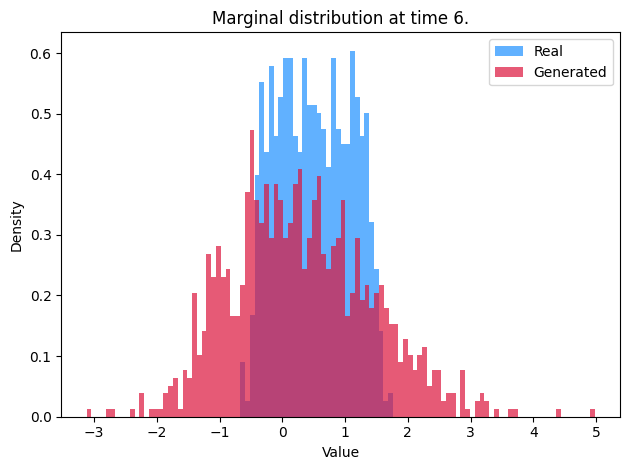

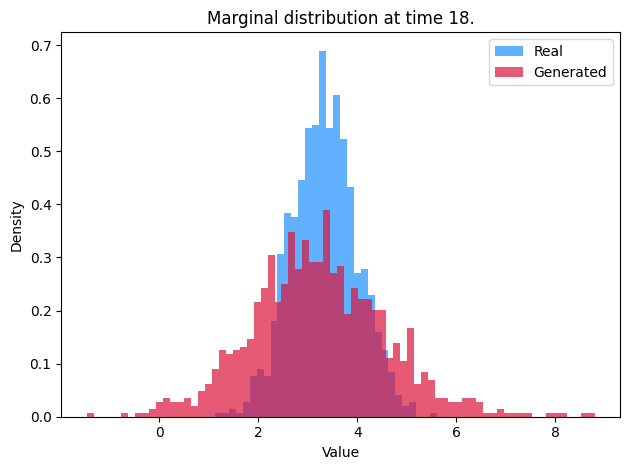

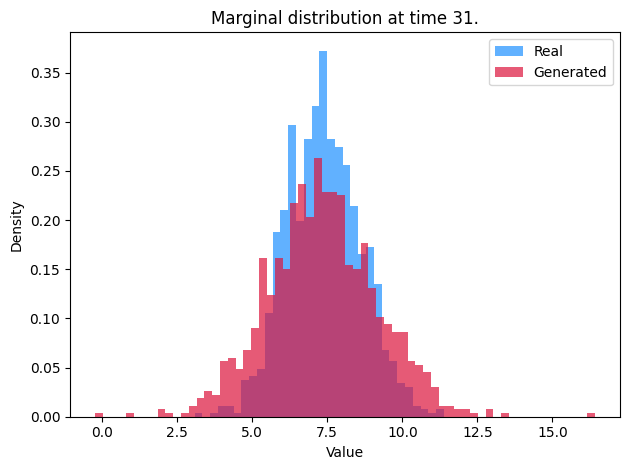

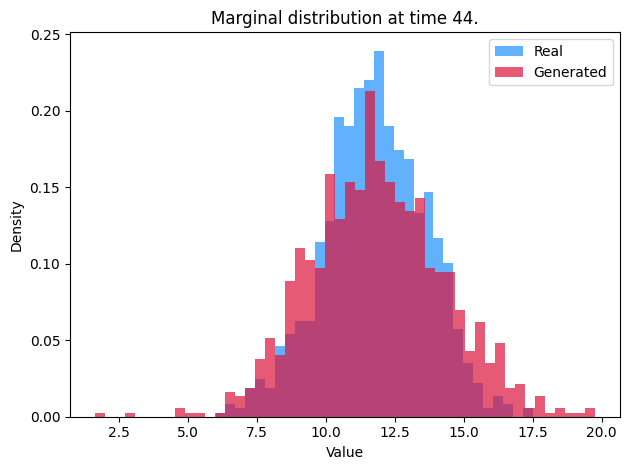

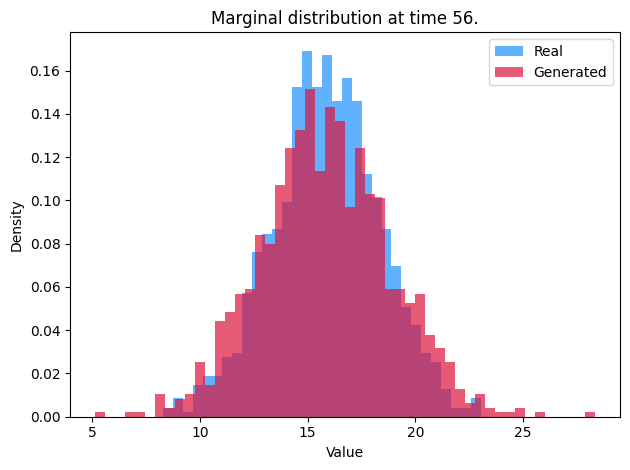

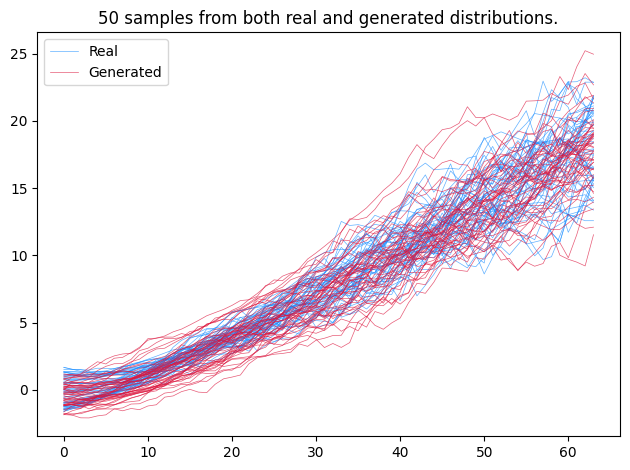

ERROR: Could not consume arg: -f
Usage: ipykernel_launcher.py -

For detailed information on this command, run:
  ipykernel_launcher.py - --help


FireExit: ignored

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
###################
# Now do normal GAN training, and plot the results.
#
# GANs are famously tricky and SDEs trained as GANs are no exception. Hopefully you can learn from our experience and
# get these working faster than we did -- we found that several tricks were often helpful to get this working in a
# reasonable fashion:
# - Stochastic weight averaging (average out the oscillations in GAN training).
# - Weight decay (reduce the oscillations in GAN training).
# - Final tanh nonlinearities in the architectures of the vector fields, as above. (To avoid the model blowing up.)
# - Adadelta (interestingly seems to be a lot better than either SGD or Adam).
# - Choosing a good learning rate (always important).
# - Scaling the weights at initialisation to be roughly the right size (chosen through empirical trial-and-error).
###################

def evaluate_loss(ts, batch_size, dataloader, generator, discriminator):
    with torch.no_grad():
        total_samples = 0
        total_loss = 0
        for real_samples, in dataloader:
            generated_samples = generator(ts, batch_size)
            generated_score = discriminator(generated_samples)
            real_score = discriminator(real_samples)
            loss = generated_score - real_score
            total_samples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_samples


def main(
        # Architectural hyperparameters. These are quite small for illustrative purposes.
        initial_noise_size=5,  # How many noise dimensions to sample at the start of the SDE.
        noise_size=3,          # How many dimensions the Brownian motion has.
        hidden_size=16,        # How big the hidden size of the generator SDE and the discriminator CDE are.
        mlp_size=16,           # How big the layers in the various MLPs are.
        num_layers=1,          # How many hidden layers to have in the various MLPs.

        # Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
        generator_lr=2e-4,      # Learning rate often needs careful tuning to the problem.
        discriminator_lr=1e-3,  # Learning rate often needs careful tuning to the problem.
        batch_size=1024,        # Batch size.
        steps=10000,            # How many steps to train both generator and discriminator for.
        init_mult1=3,           # Changing the initial parameter size can help.
        init_mult2=0.5,         #
        weight_decay=0.01,      # Weight decay.
        swa_step_start=5000,    # When to start using stochastic weight averaging.

        # Evaluation and plotting hyperparameters
        steps_per_print=10,                   # How often to print the loss.
        num_plot_samples=50,                  # How many samples to use on the plots at the end.
        plot_locs=(0.1, 0.3, 0.5, 0.7, 0.9),  # Plot some marginal distributions at this proportion of the way along.
):
    is_cuda = torch.cuda.is_available()
    device = 'cuda' if is_cuda else 'cpu'
    if not is_cuda:
        print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

    # Data
    ts, data_size, train_dataloader = get_data(batch_size=batch_size, device=device)
    infinite_train_dataloader = (elem for it in iter(lambda: train_dataloader, None) for elem in it)

    # Models
    generator = Generator(data_size, initial_noise_size, noise_size, hidden_size, mlp_size, num_layers).to(device)
    discriminator = Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
    # Weight averaging really helps with GAN training.
    averaged_generator = swa_utils.AveragedModel(generator)
    averaged_discriminator = swa_utils.AveragedModel(discriminator)

    # Picking a good initialisation is important!
    # In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
    # size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
    # Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
    # What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
    # (e.g. pretraining the t=0 distribution)
    with torch.no_grad():
        for param in generator._initial.parameters():
            param *= init_mult1
        for param in generator._func.parameters():
            param *= init_mult2

    # Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
    generator_optimiser = torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
    discriminator_optimiser = torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
                                                   weight_decay=weight_decay)

    # Train both generator and discriminator.
    trange = tqdm.tqdm(range(steps))
    for step in trange:
        real_samples, = next(infinite_train_dataloader)

        generated_samples = generator(ts, batch_size)
        generated_score = discriminator(generated_samples)
        real_score = discriminator(real_samples)
        loss = generated_score - real_score
        loss.backward()

        for param in generator.parameters():
            param.grad *= -1
        generator_optimiser.step()
        discriminator_optimiser.step()
        generator_optimiser.zero_grad()
        discriminator_optimiser.zero_grad()

        ###################
        # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
        # LipSwish activation functions).
        ###################
        with torch.no_grad():
            for module in discriminator.modules():
                if isinstance(module, torch.nn.Linear):
                    lim = 1 / module.out_features
                    module.weight.clamp_(-lim, lim)

        # Stochastic weight averaging typically improves performance.
        if step > swa_step_start:
            averaged_generator.update_parameters(generator)
            averaged_discriminator.update_parameters(discriminator)

        if (step % steps_per_print) == 0 or step == steps - 1:
            total_unaveraged_loss = evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
            if step > swa_step_start:
                total_averaged_loss = evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
                                                    averaged_discriminator.module)
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
                             f"Loss (averaged): {total_averaged_loss:.4f}")
            else:
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")
    generator.load_state_dict(averaged_generator.module.state_dict())
    discriminator.load_state_dict(averaged_discriminator.module.state_dict())

    _, _, test_dataloader = get_data(batch_size=batch_size, device=device)

    plot(ts, generator, test_dataloader, num_plot_samples, plot_locs)


if __name__ == '__main__':
    fire.Fire(main)

###################
# And that's (one way of doing) an SDE as a GAN. Have fun.
###################

In [ ]:
###################
# Appendix: discriminators for a neural SDE
#
# This is a little long, but should all be quite straightforward. By the end of this you should have a comprehensive
# knowledge of how these things fit together.
#
# Let Y be the real/generated sample, and let H be the hidden state of the discriminator.
# For real data, then Y is some interpolation of an (irregular) time series. (As with neural CDEs, if you're familiar -
# for a nice exposition on this see https://github.com/patrick-kidger/torchcde/blob/master/example/irregular_data.py.)
# In the case of generated data, then Y is _either_ the continuous-time sample produced by sdeint, _or_ it is an
# interpolation (probably linear interpolation) of the generated sample between particular evaluation points, We'll
# refer to these as cases (*) and (**) respectively.
#
# In terms of the mathematics, our options for the discriminator are:
# (a1) Solve dH(t) = f(t, H(t)) dt + g(t, H(t)) dY(t),
# (a2) Solve dH(t) = (f, g)(t, H(t)) d(t, Y(t))
# (b) Solve dH(t) = f(t, H(t), Y(t)) dt.
# Option (a1) is what is stated in the paper "Neural SDE as Infinite-Dimensional GANs".
# Option (a2) is theoretically the same as (a1), but the drift and diffusion have been merged into a single function,
# and the sample Y has been augmented with time. This can sometimes be a more helpful way to think about things.
# Option (b) is a special case of the first two, by Appendix C of arXiv:2005.08926.
# [Note that just dH(t) = g(t, H(t)) dY(t) would _not_ be enough, by what's known as the tree-like equivalence property.
#  It's a bit technical, but the basic idea is that the discriminator wouldn't be able to tell how fast we traverse Y.
#  This is a really easy mistake to make; make sure you don't fall into it.]
#
# Whether we use (*) or (**), and (a1) or (a2) or (b), doesn't really affect the quality of the discriminator, as far as
# we know. However, these distinctions do affect how we solve them in terms of code. Depending on each combination, our
# options are to use a solver of the following types:
#
#      | (a1)   (a2)   (b)
# -----+----------------------
#  (*) | SDE           SDE
# (**) |        CDE    ODE
#
# So, (*) implies using an SDE solver: the continuous-time sample is only really available inside sdeint, so if we're
# going to use the continuous-time sample then we need to solve generator and discriminator together inside a single SDE
# solve. In this case, as our generator takes the form
# Y(t) = l(X(t)) with dX(t) = μ(t, X(t)) dt + σ(t, X(t)) dW(t),
# then
# dY(t) = l(X(t)) dX(t) = l(X(t))μ(t, X(t)) dt + l(X(t))σ(t, X(t)) dW(t).
# Then for (a1) we get
# dH(t) = ( f(t, H(t)) + g(t, H(t))l(X(t))μ(t, X(t)) ) dt + g(t, H(t))l(X(t))σ(t, X(t)) dW(t),
# which we can now put together into one big SDE solve:
#  ( X(t) )   ( μ(t, X(t)                                )      ( σ(t, X(t))                  )
# d( Y(t) ) = ( l(X(t))μ(t, X(t)                         ) dt + ( l(X(t))σ(t, X(t))           ) dW(t)
#  ( H(t) )   ( f(t, H(t)) + g(t, H(t))l(X(t))μ(t, X(t)) )      ( g(t, H(t))l(X(t))σ(t, X(t)) ),
# whilst for (b) we can put things together into one big SDE solve:
#  ( X(t) )   ( μ(t, X(t))       )      ( σ(t, X(t))        )
# d( Y(t) ) = ( l(X(t))μ(t, X(t) ) dt + ( l(X(t))σ(t, X(t)) ) dW(t)
#  ( H(t) )   ( f(t, H(t), Y(t)) )      ( 0                 )
#
# Phew, what a lot of stuff to write down. Don't be put off by this: there's no complicated algebra, it's literally just
# substituting one equation into another. Also, note that all of this is for the _generated_ data. If using real data,
# then Y(t) is as previously described always an interpolation of the data. If you're able to evaluate the derivative of
# the interpolation then you can then apply (a1) by rewriting it as dY(t) = (dY/dt)(t) dt and substituting in. If you're
# able to evaluate the interpolation itself then you can apply (b) directly.
#
# The benefit of using (*) is that everything can be done inside a single SDE solve, which is important if you're
# thinking about using adjoint methods and the like, for memory efficiency. The downside is that the code gets a bit
# more complicated: you need to be able to solve just the generator on its own (to produce samples at inference time),
# just the discriminator on its own (to evaluate the discriminator on the real data), and the combined
# generator-discriminator system (to evaluate the discriminator on the generated data).
#
# Right, let's move on to (**). In comparison, this is much simpler. We don't need to substitute in anything. We're just
# taking our generated data, sampling it at a bunch of points, and then doing some kind of interpolation (probably
# linear interpolation). Then we either solve (a2) directly with a CDE solver (regardless of whether we're using real or
# generated data), or solve (b) directly with an ODE solver (regardless of whether we're using real or generated data).
#
# The benefit of this is that it's much simpler to code: unlike (*) we can separate the generator and discriminator, and
# don't ever need to combine them. Also, real and generated data is treated the same in the discriminator. (Which is
# arguably a good thing anyway.) The downside is that we can't really take advantage of things like adjoint methods to
# backpropagate efficiently through the generator, because we need to produce (and thus store) our generated sample at
# lots of time points, which reduces the memory efficiency.
#
# Note that the use of ODE solvers for (**) is only valid because we're using _interpolated_ real or generated data,
# and we're assuming that we're using some kind of interpolation that is at least piecewise smooth. (For example, linear
# interpolation is piecewise smooth.) It wouldn't make sense to apply ODE solvers to some rough signal like Brownian
# motion - that's what case (*) and SDE solvers are about.
#
# Right, let's wrap up this wall of text. Here, we use option (**), (a2). This is arguably the simplest option, and
# is chosen as we'd like to keep the code readable in this example. To solve the CDEs we use the CDE solvers available
# through torchcde: https://github.com/patrick-kidger/torchcde.
###################